In [3]:
import tensorflow as tf
import gym
import numpy as np

import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display
%matplotlib inline

from matplotlib import animation
from JSAnimation.IPython_display import display_animation

C:\Users\SP.000\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\SP.000\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\SP.000\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\SP.000\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: P

In [4]:
def display_frames_as_gif(frames, filename_gif = None):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename_gif: 
        anim.save(filename_gif, writer = 'imagemagick', fps=20)
    display(display_animation(anim, default_mode='loop'))


In [5]:
def discount_and_norm_rewards(rewards,gamma):
        discounted_rewards = np.zeros_like(rewards)
        cumulative = 0
        for t in reversed(range(len(episode_rewards))):
            cumulative = cumulative * gamma + episode_rewards[t]
            discounted_rewards[t] = cumulative

        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)
        return discounted_rewards


In [6]:
def get_action(session,observation,outputs_softmax):
   
    # Reshape observation to (num_features, 1)
    observation = observation[:, np.newaxis]

    # Run forward propagation to get softmax probabilities
    prob_weights = session.run(outputs_softmax, feed_dict = {X: observation})

    # Select action using a biased sample
    # this will return the index of the action we've sampled
    action = np.random.choice(range(len(prob_weights.ravel())), p=prob_weights.ravel())
    return action


In [7]:
learning_rate =0.01
gamma = 0.95
num_episodes=5
env = gym.make('CartPole-v0')
env = env.unwrapped
n_x = env.observation_space.shape[0]
n_y = env.action_space.n

In [8]:
session = tf.Session()

In [9]:
# Create placeholders
with tf.name_scope('inputs'):
    X = tf.placeholder(tf.float32, shape=(n_x, None), name="X")
    Y = tf.placeholder(tf.float32, shape=(n_y, None), name="Y")
    discounted_rewards_norm_tf = tf.placeholder(tf.float32, [None, ], name="actions_value")

# Initialize parameters
units_layer_1 = 10
units_layer_2 = 10
units_output_layer = n_y
with tf.name_scope('parameters'):
    W1 = tf.get_variable("W1", [units_layer_1, n_x], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [units_layer_1, 1], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    W2 = tf.get_variable("W2", [units_layer_2, units_layer_1], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [units_layer_2, 1], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    W3 = tf.get_variable("W3", [n_y, units_layer_2], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [n_y, 1], initializer = tf.contrib.layers.xavier_initializer(seed=1))

# Forward prop
with tf.name_scope('layer_1'):
    Z1 = tf.add(tf.matmul(W1,X), b1)
    A1 = tf.nn.relu(Z1)
with tf.name_scope('layer_2'):
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
with tf.name_scope('layer_3'):
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    A3 = tf.nn.softmax(Z3)

# Softmax outputs, we need to transpose as tensorflow nn functions expects them in this shape
logits = tf.transpose(Z3)
labels = tf.transpose(Y)
outputs_softmax = tf.nn.softmax(logits, name='A3')

with tf.name_scope('loss'):
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    loss = tf.reduce_mean(neg_log_prob * discounted_rewards_norm_tf)  # reward guided loss

with tf.name_scope('train'):
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [10]:
all_rewards =[]
is_rendering = False
load_path = "./models/CartPole-v0.ckpt"
saver = tf.train.Saver()

is_rendering = True
max_steps =200
if load_path:
    saver.restore(session,load_path)
best_episode_frames = []
#session.run(tf.global_variables_initializer())
for episode in range(num_episodes):
    observation = env.reset()
    if is_rendering:
        frames = []
    
    episode_reward = 0
    episode_observations,episode_rewards,episode_actions= [],[],[]
    for i in range(max_steps):
        
        if is_rendering:
            frame = env.render(mode = 'rgb_array')
            frames.append(frame)
        action = get_action(session,observation,outputs_softmax)
        observation_, reward_, done, info = env.step(action)
        episode_observations.append(observation_)
        episode_rewards.append(reward_)

        # Store actions as list of arrays
        # e.g. for n_y = 2 -> [ array([ 1.,  0.]), array([ 0.,  1.]), array([ 0.,  1.]), array([ 1.,  0.]) ]
        action_ = np.zeros(n_y)
        action_[action] = 1
        episode_actions.append(action_)
        
        if done or i == max_steps -1 :
            episode_rewards_sum = sum(episode_rewards)
            all_rewards.append(episode_rewards_sum)
            max_reward_so_far = np.amax(all_rewards)

            print("==========================================")
            print("Episode: ", episode)
            print("Reward: ", episode_rewards_sum)
            print("Max reward so far: ", max_reward_so_far)
            if(episode_rewards_sum >= max_reward_so_far):
                best_episode_frames = frames.copy()

            # 4. Train neural network
            
            discounted_rewards_norm = discount_and_norm_rewards(episode_rewards,gamma)
            session.run(train_op, feed_dict={
             X: np.vstack(episode_observations).T,
             Y: np.vstack(np.array(episode_actions)).T,
             discounted_rewards_norm_tf: discounted_rewards_norm,
            })
            
            break
            
            
        observation = observation_

            



        


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./models/CartPole-v0.ckpt
Episode:  0
Reward:  200.0
Max reward so far:  200.0
Episode:  1
Reward:  200.0
Max reward so far:  200.0
Episode:  2
Reward:  200.0
Max reward so far:  200.0
Episode:  3
Reward:  200.0
Max reward so far:  200.0
Episode:  4
Reward:  200.0
Max reward so far:  200.0


MovieWriter imagemagick unavailable.



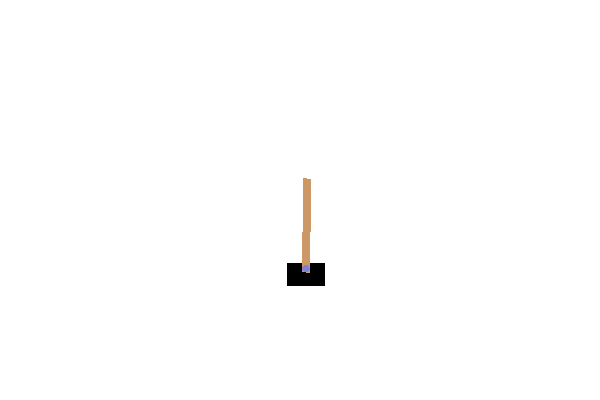
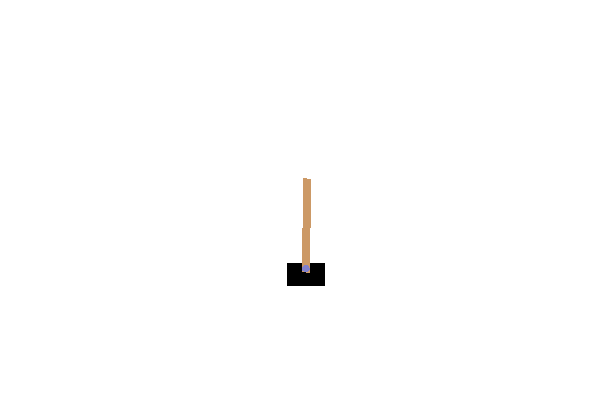
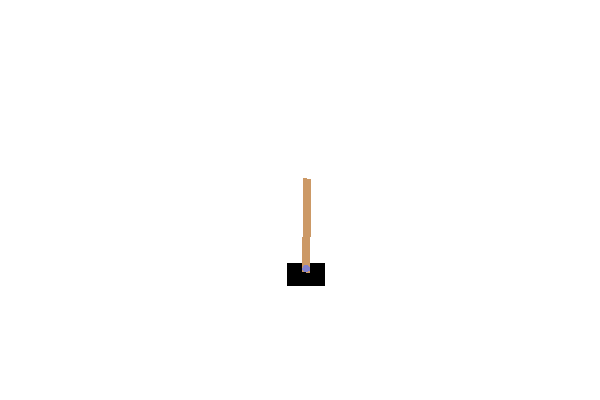
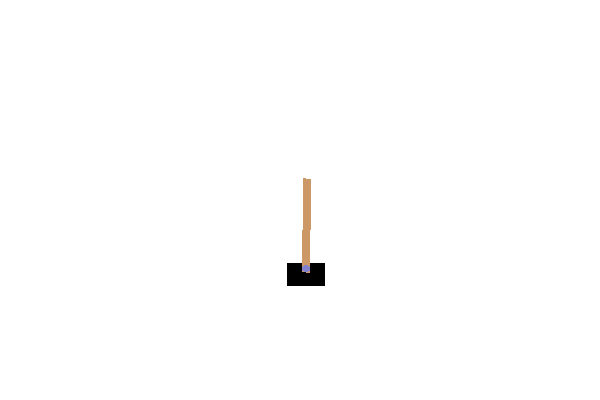
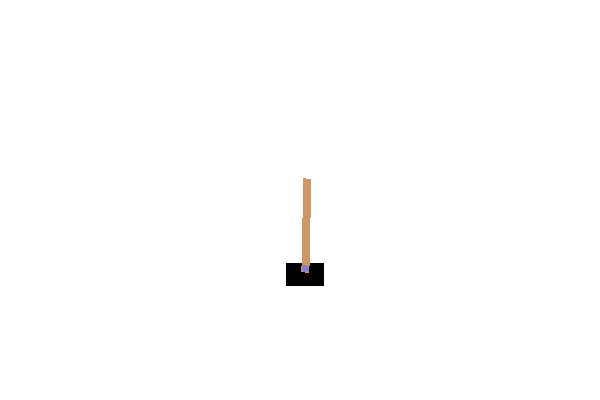
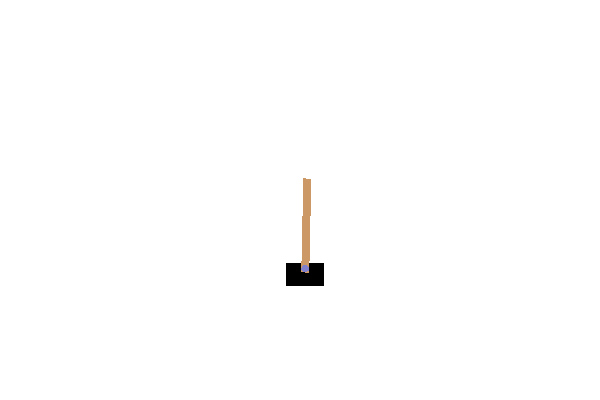
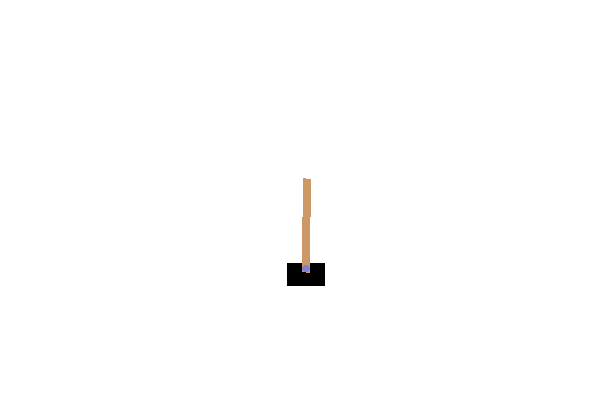
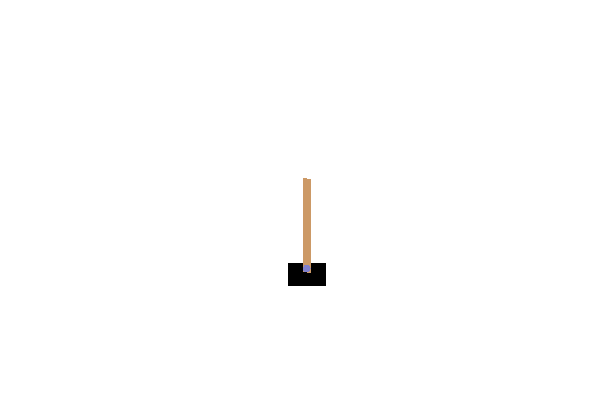
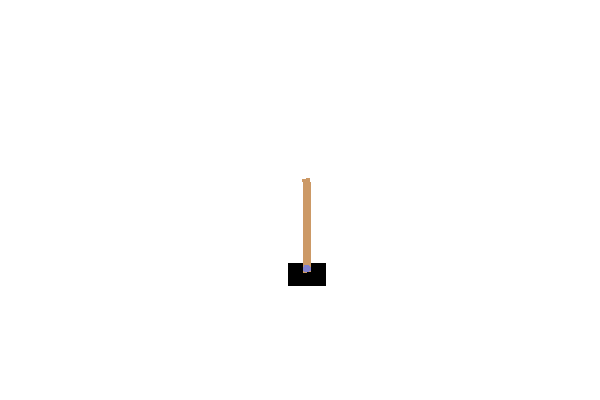
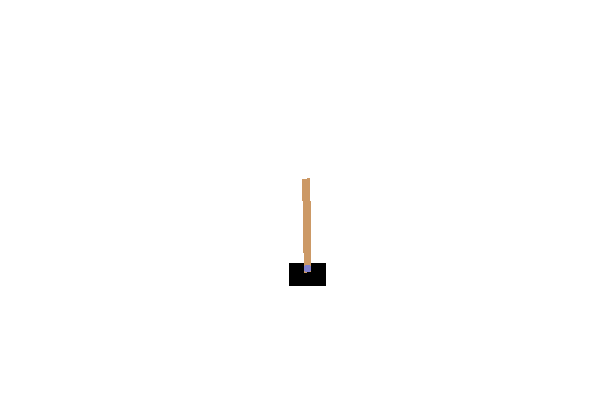
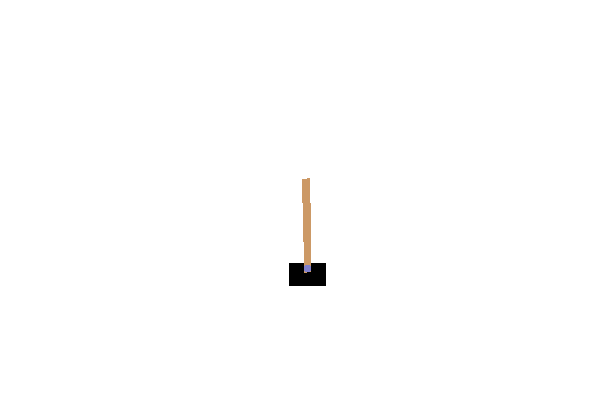
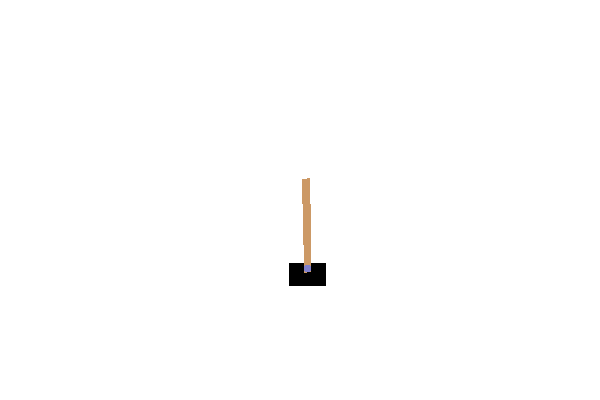
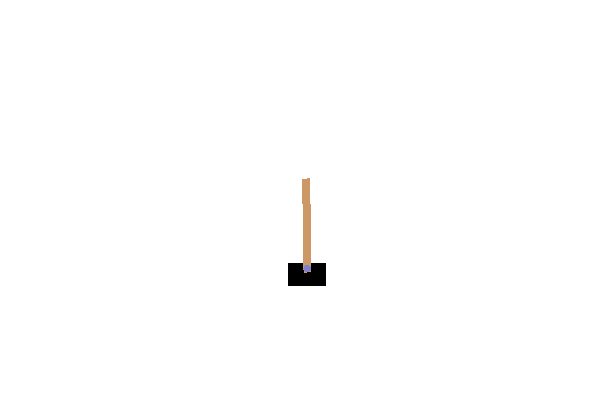
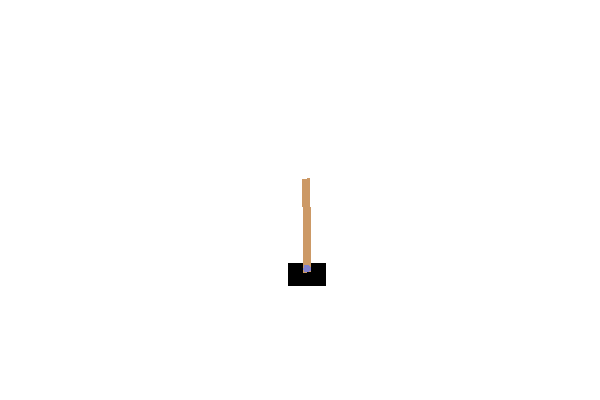
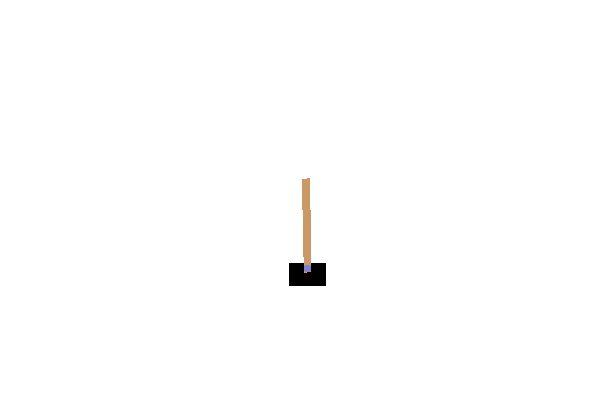
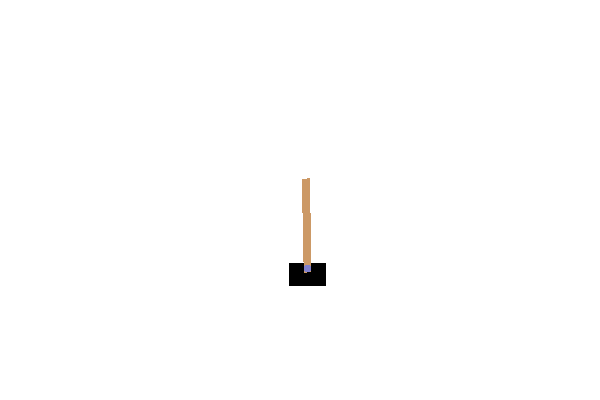
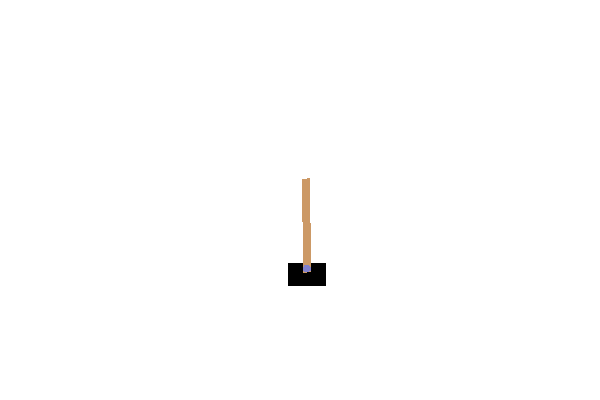
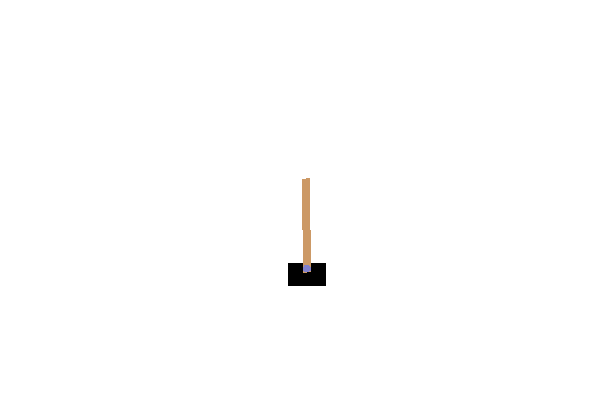
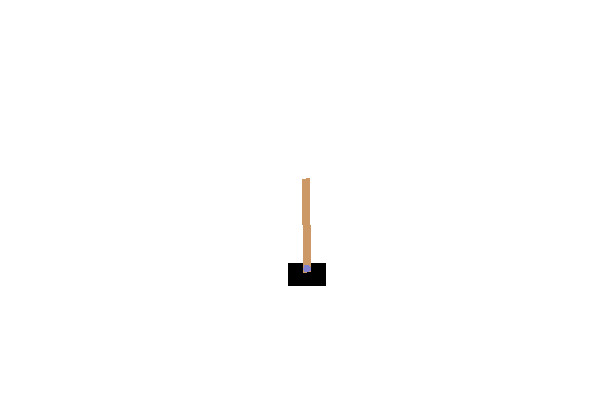
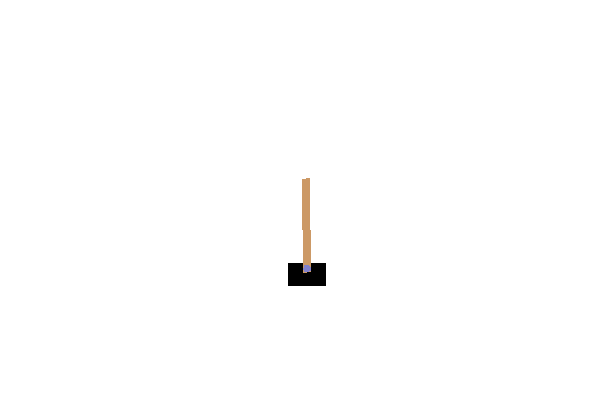
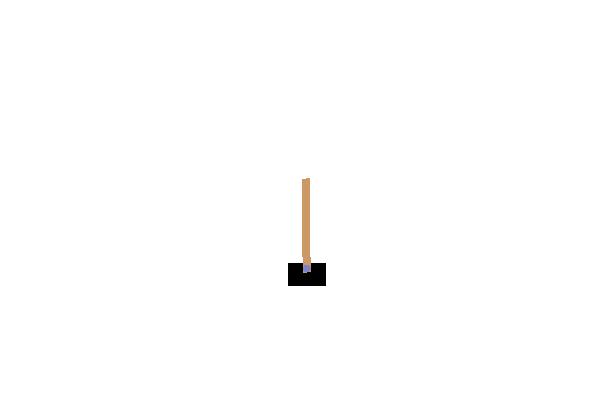
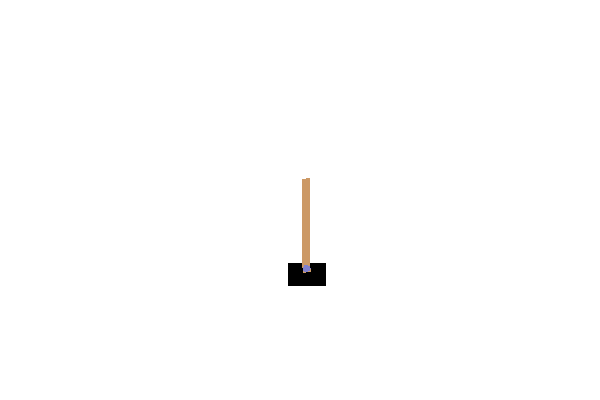
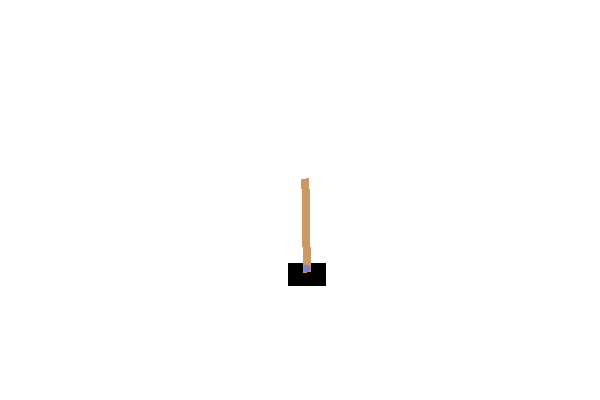
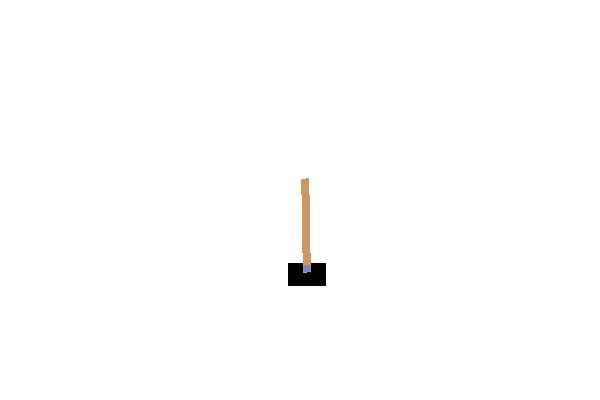
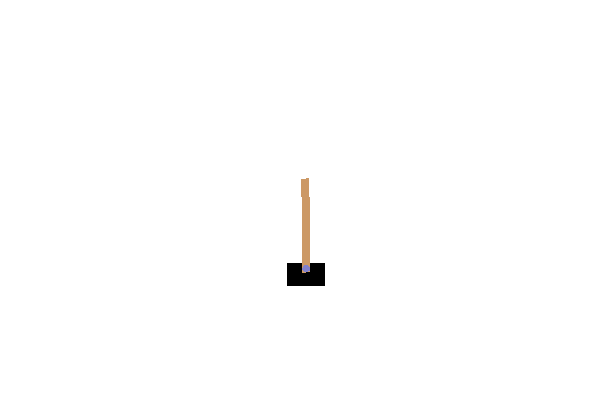
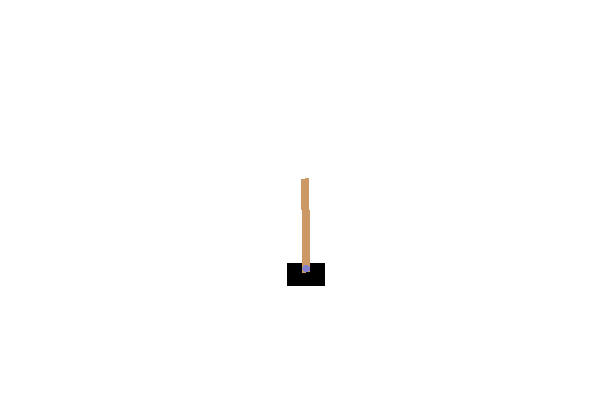
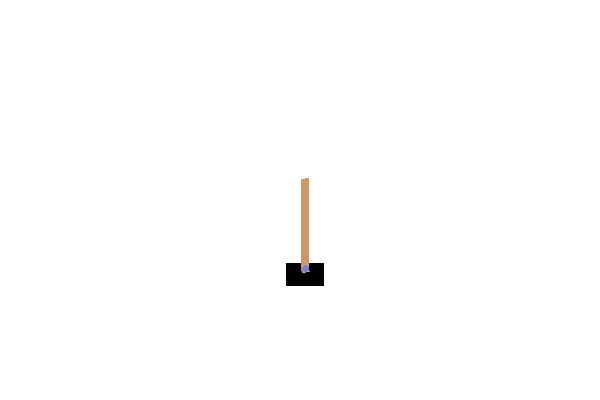
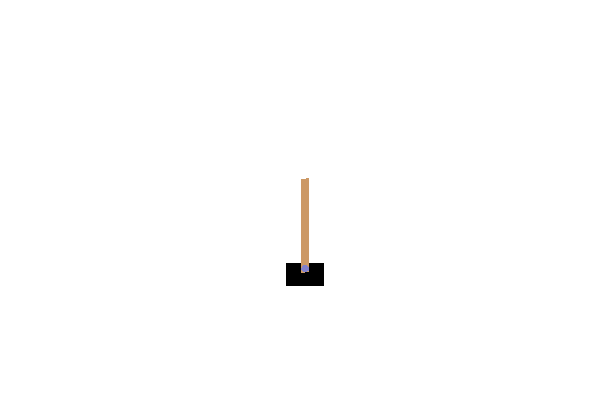
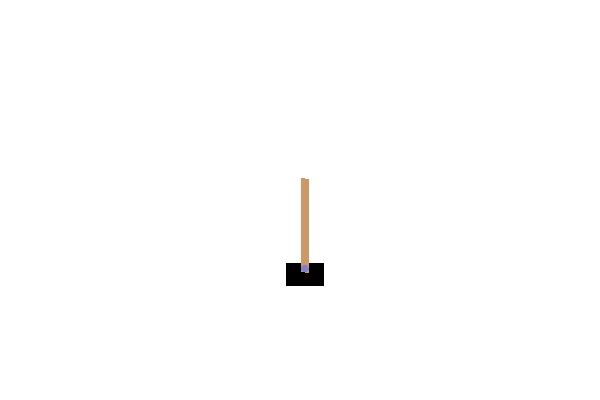
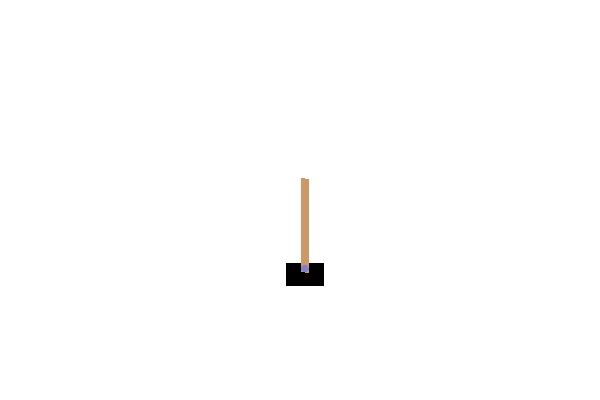
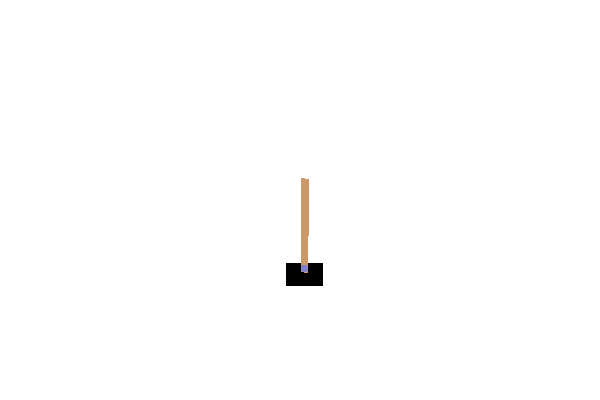
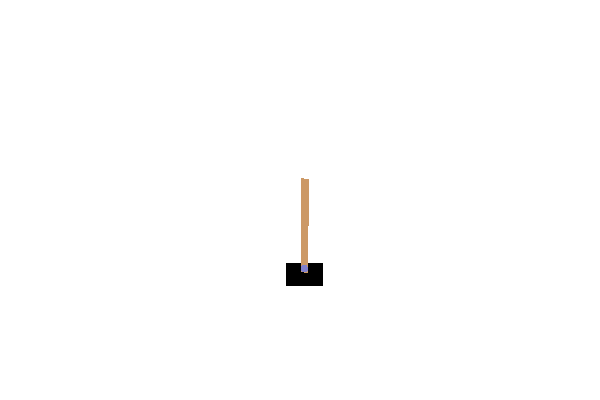
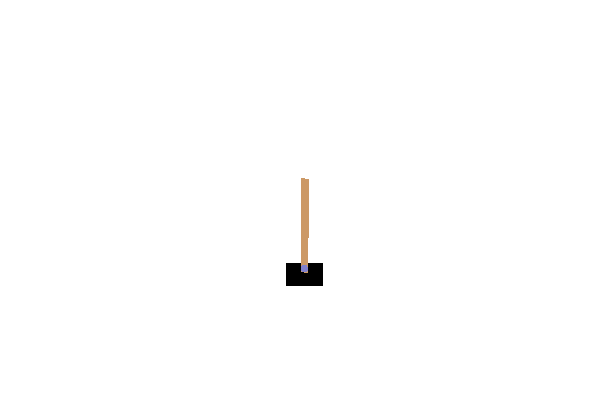
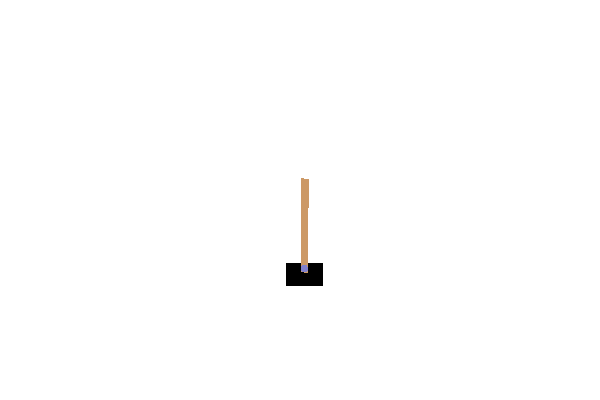
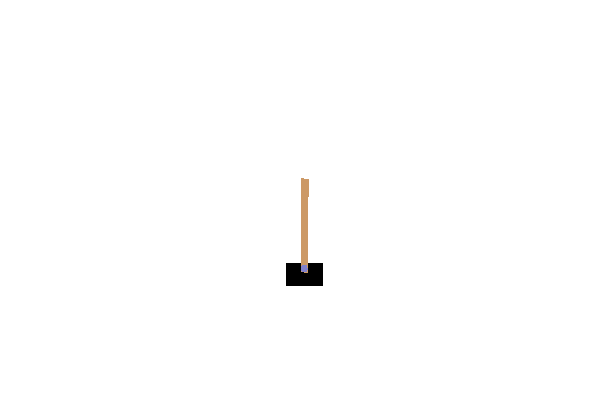
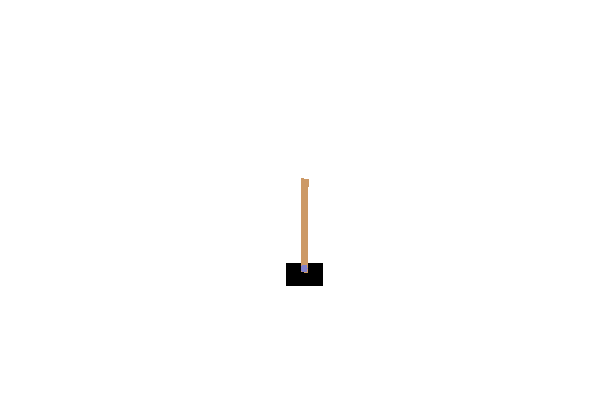
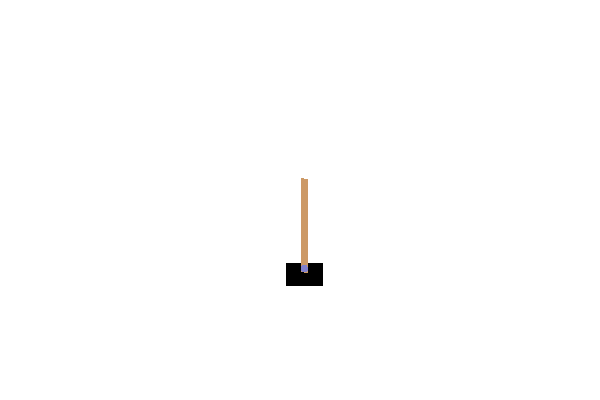
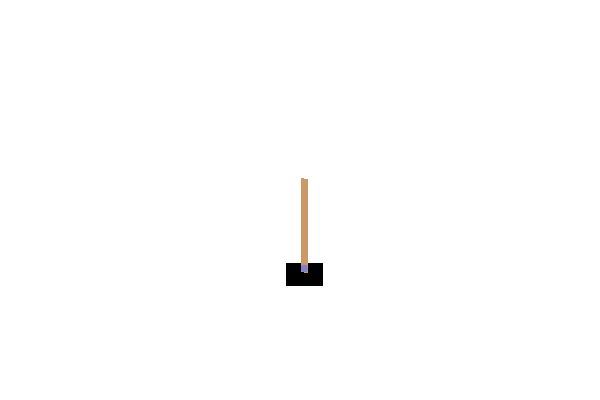
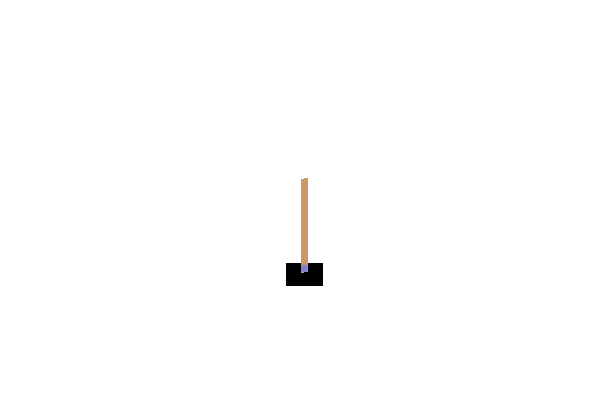
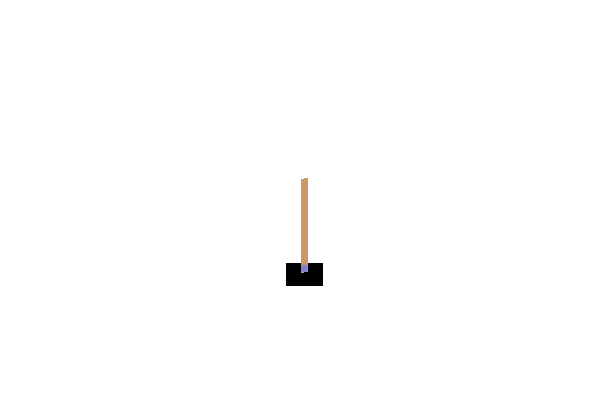
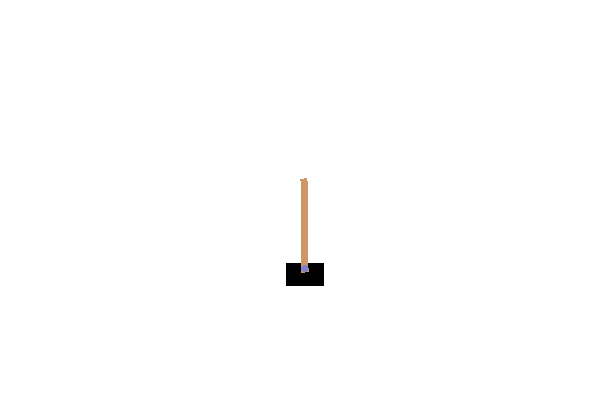
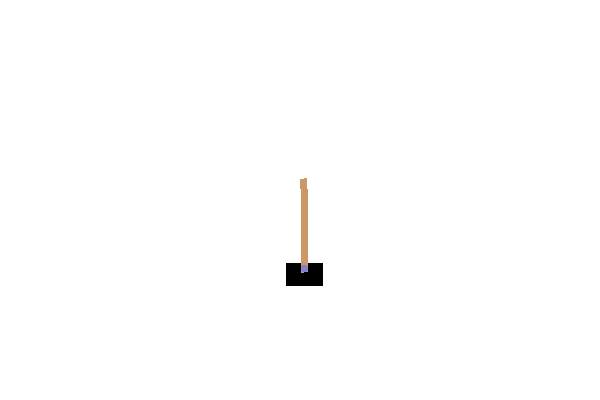
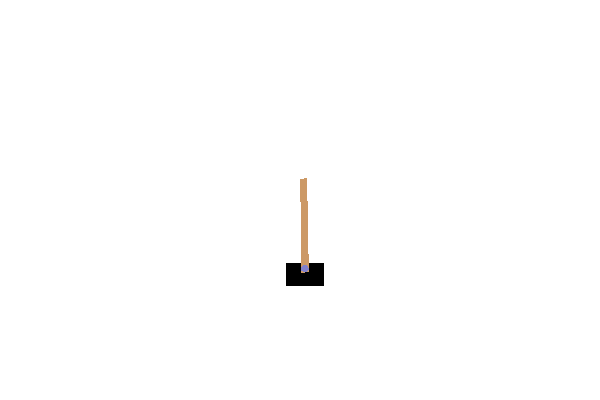
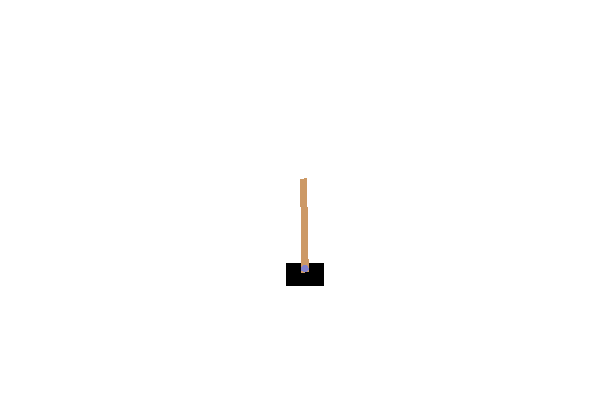
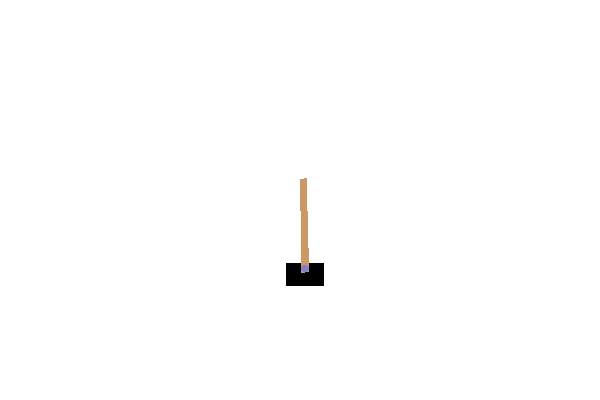
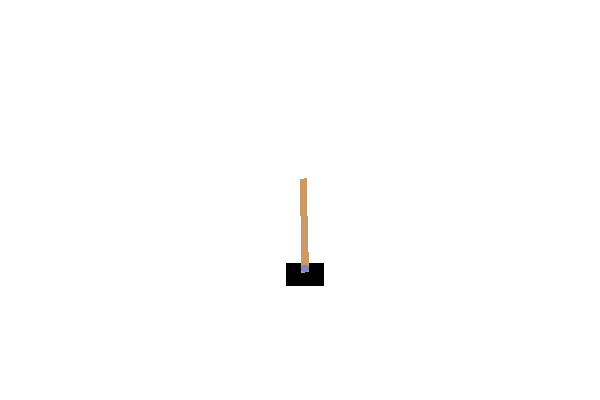
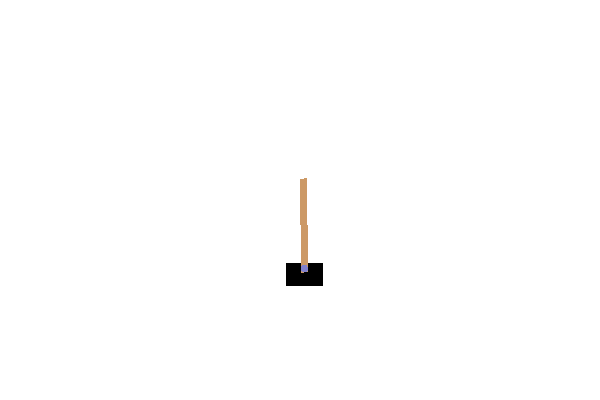
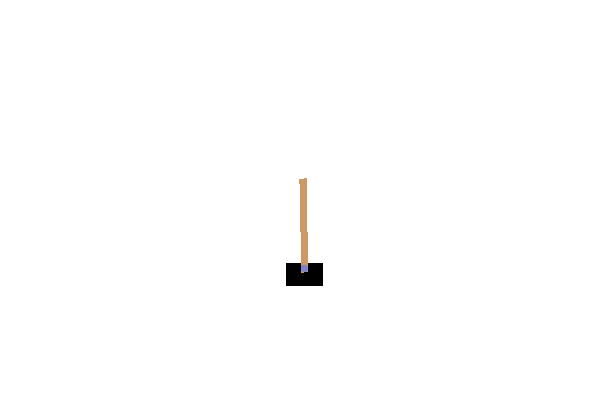
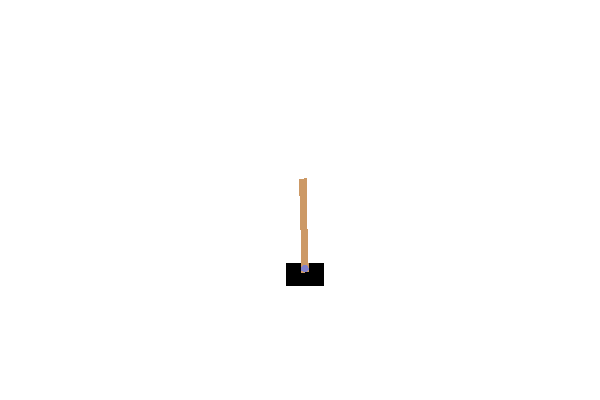
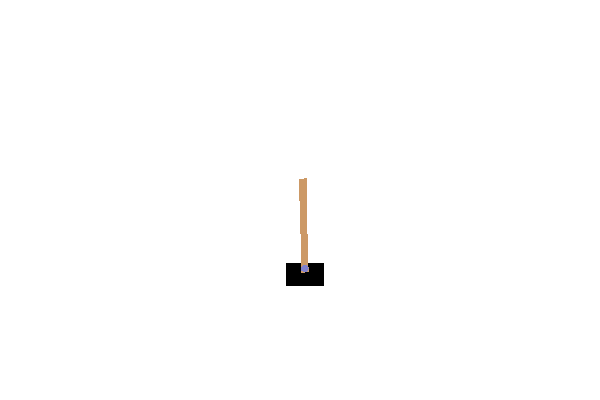
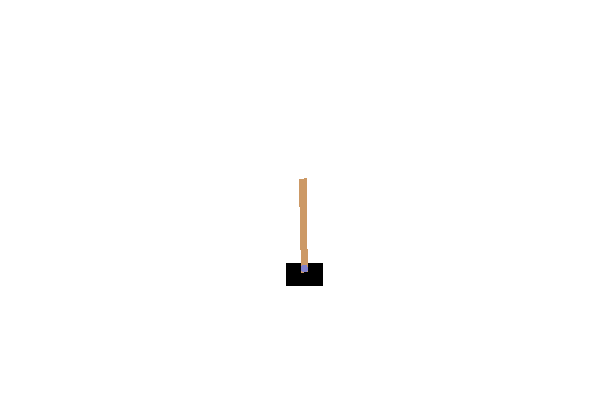
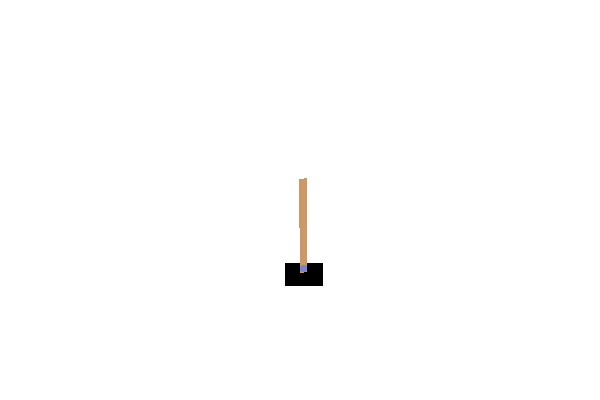
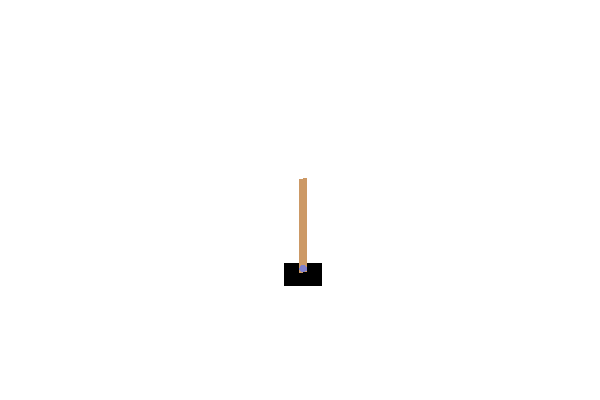
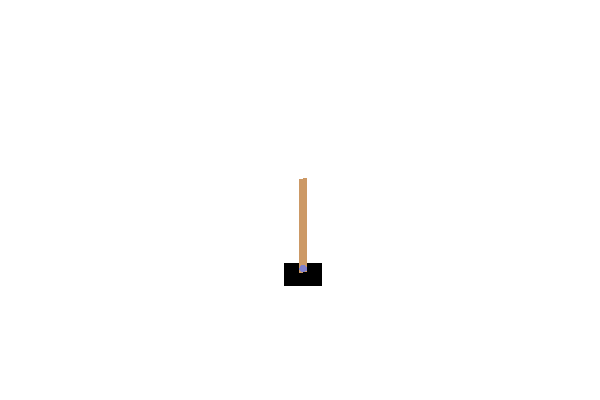
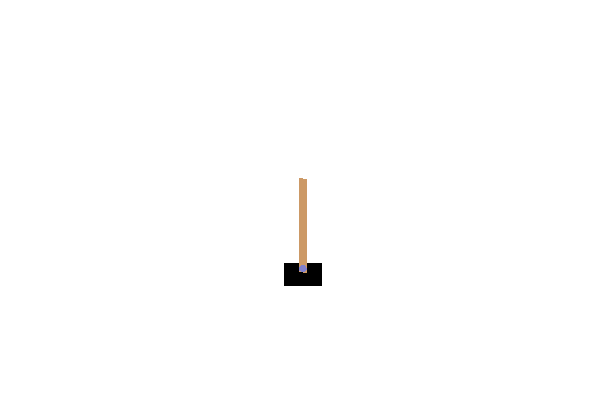
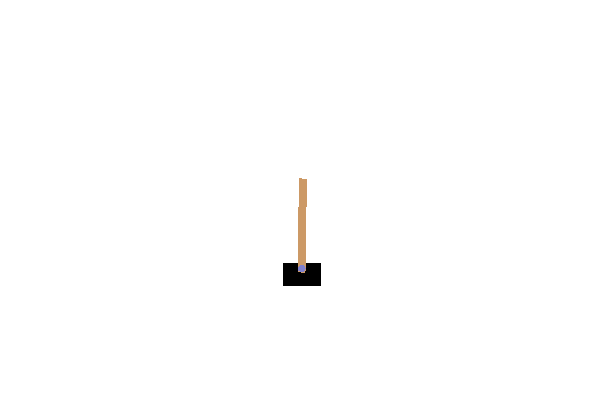
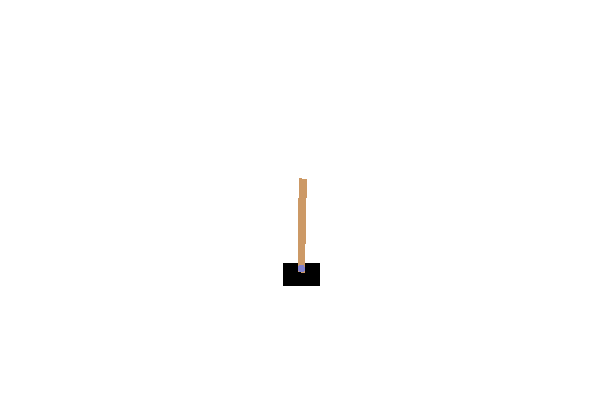
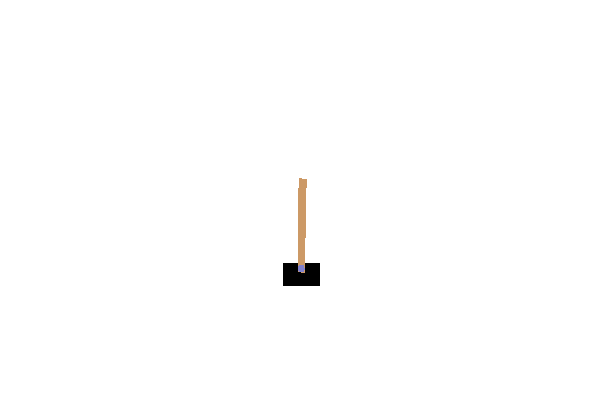
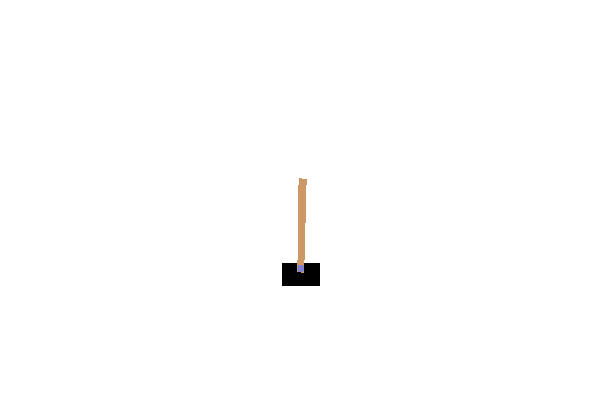
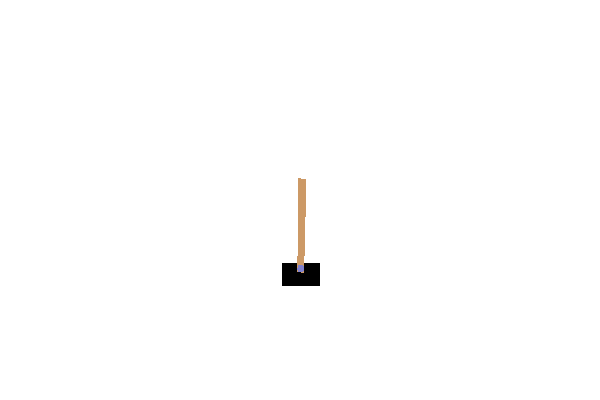
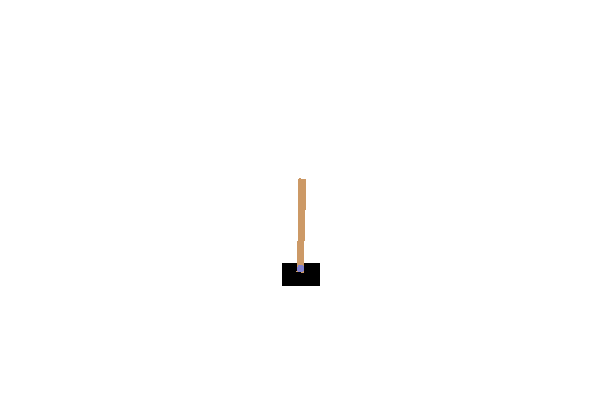
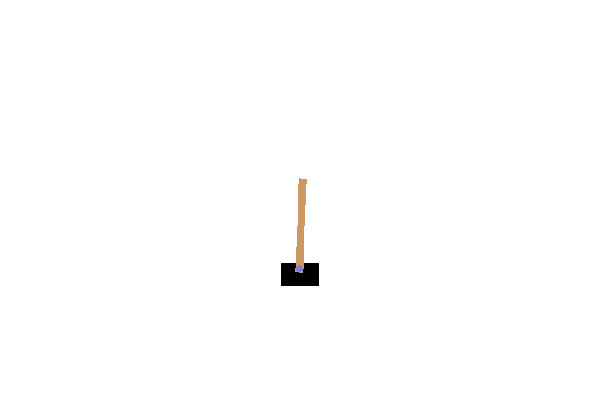
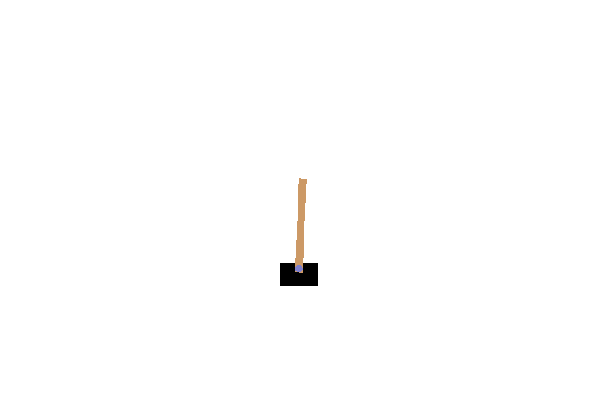
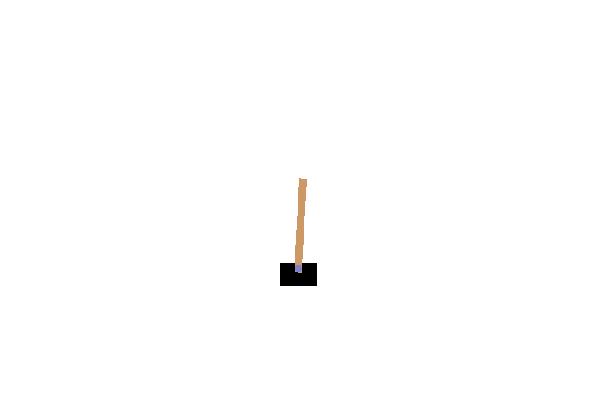
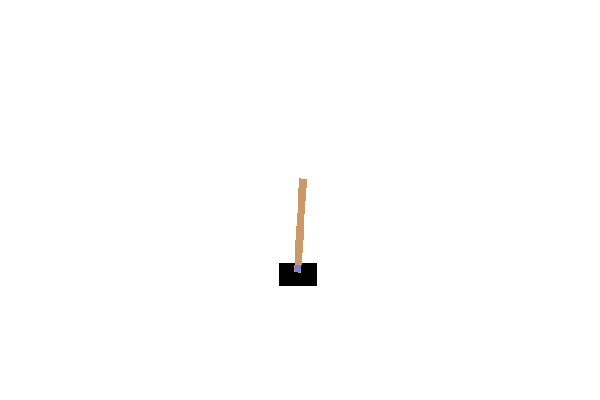
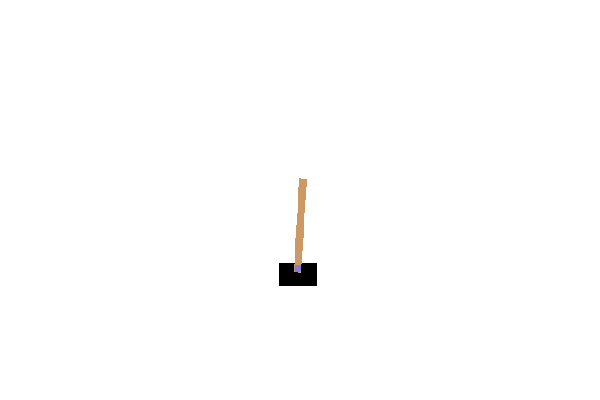
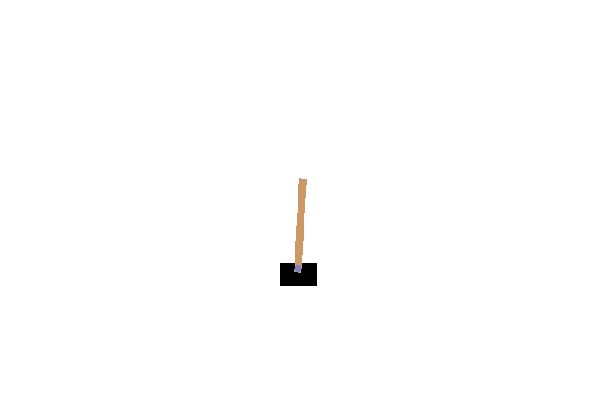
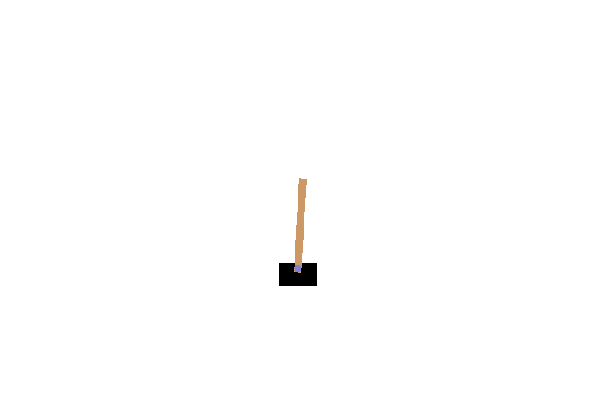
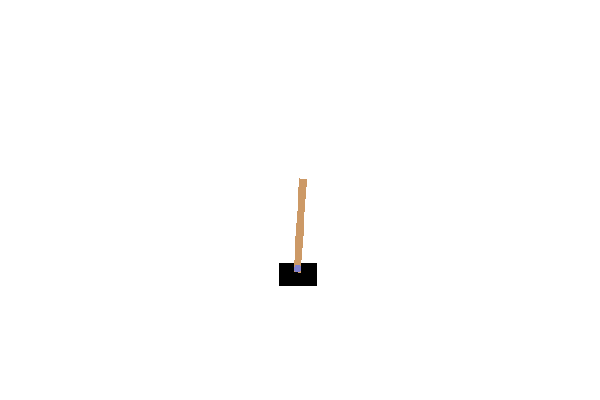
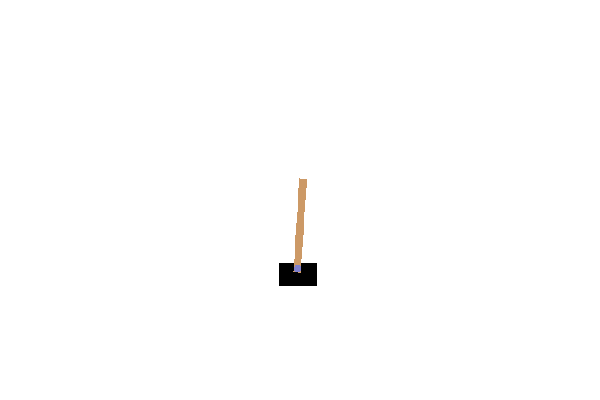
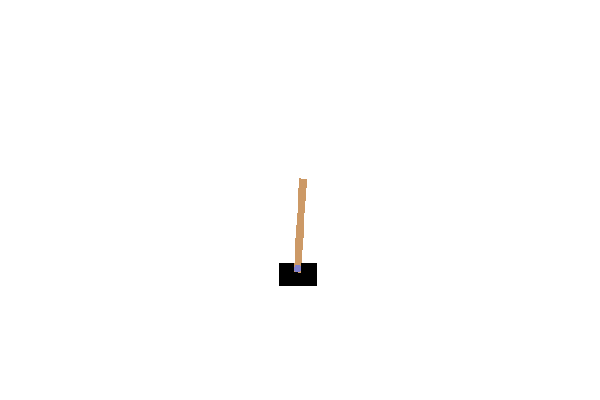
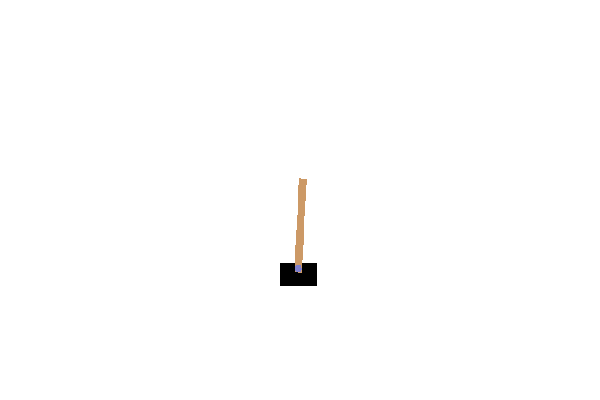
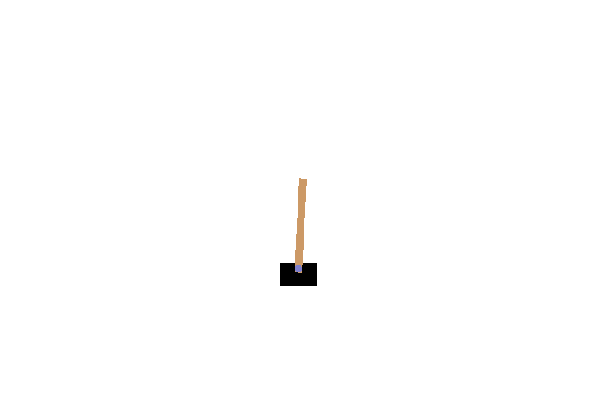
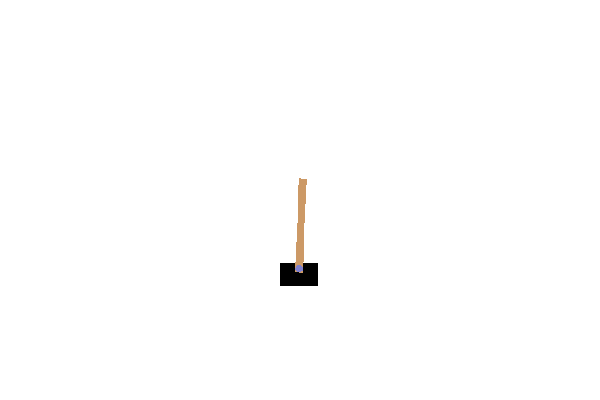
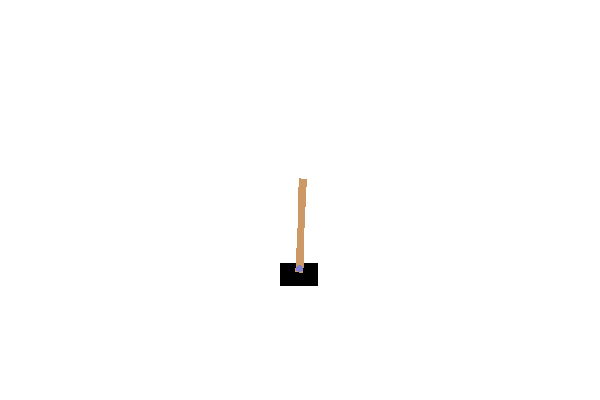
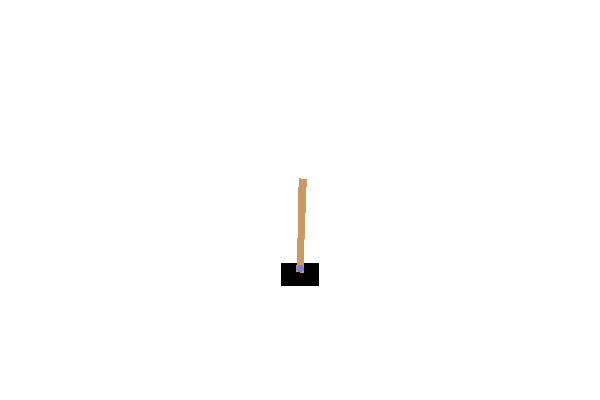
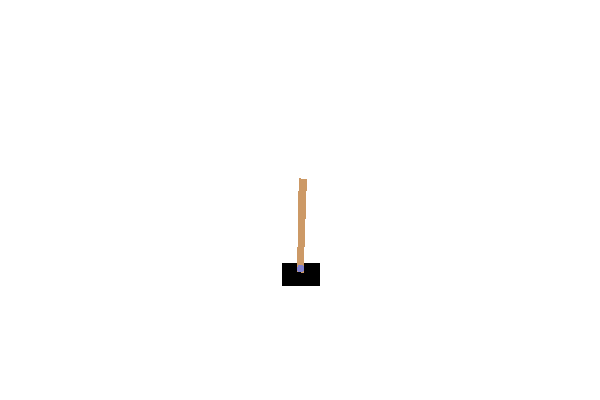
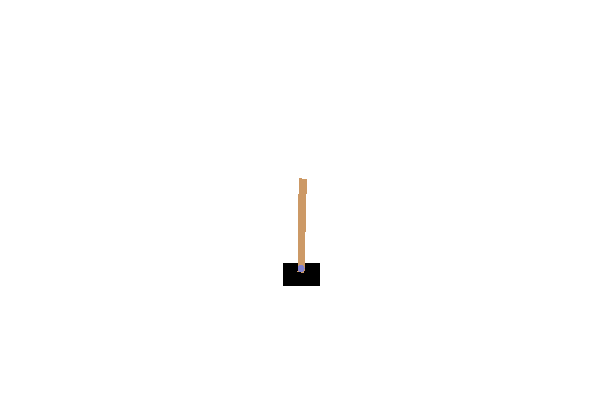
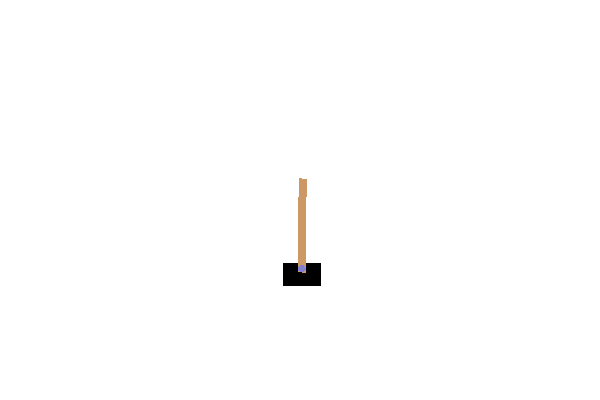
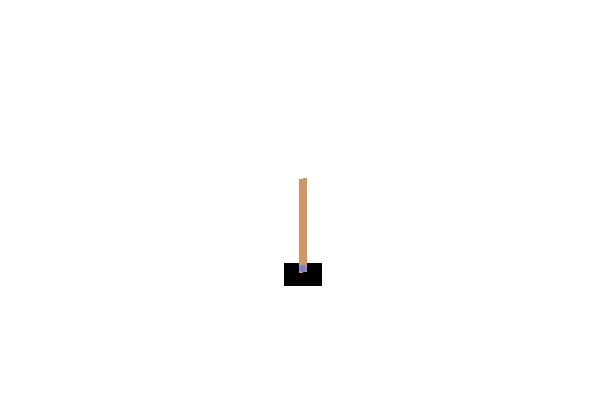
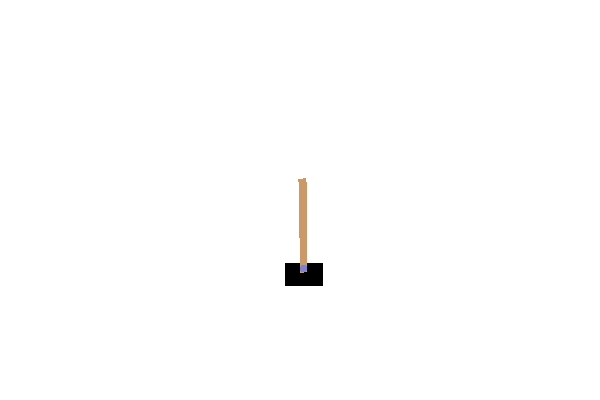
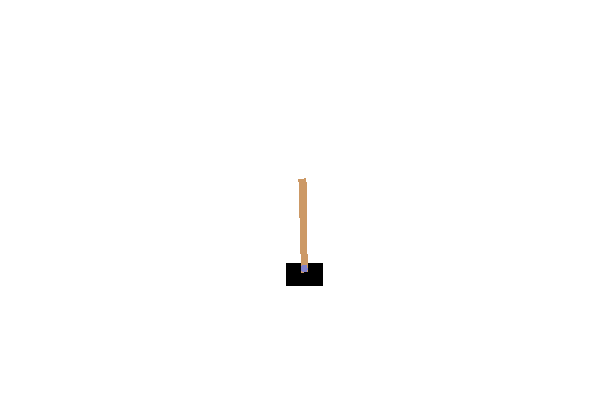
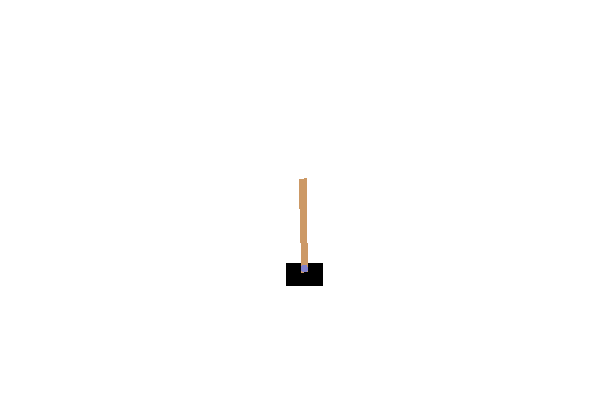
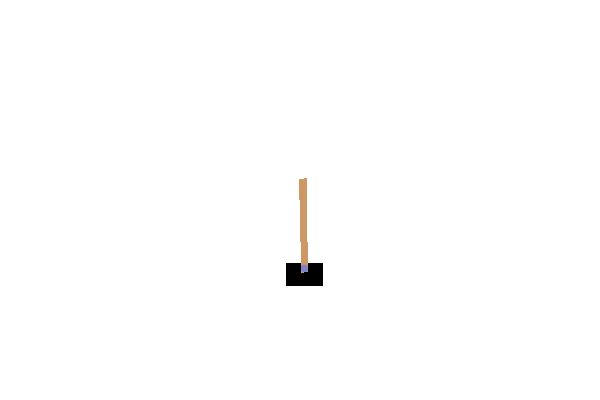
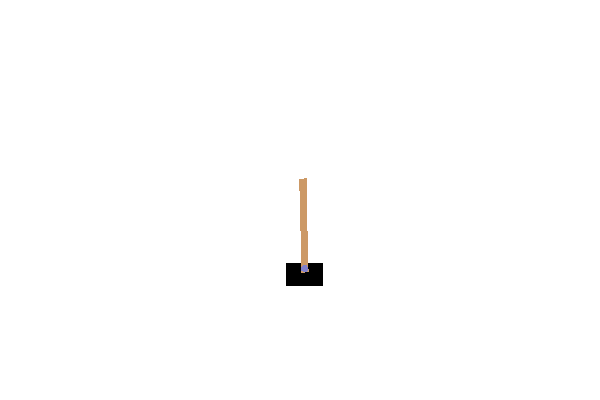
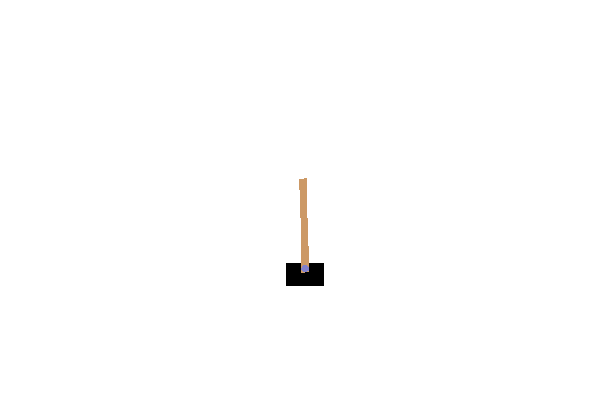
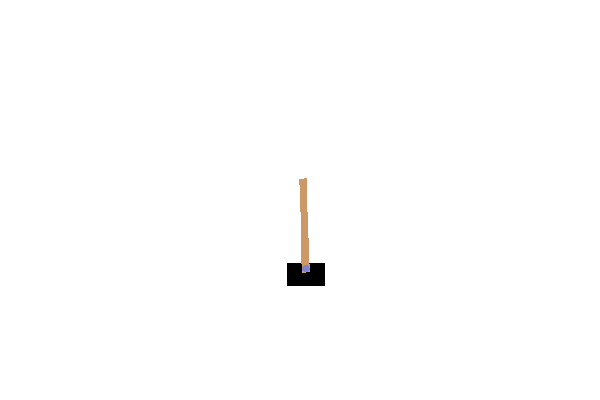
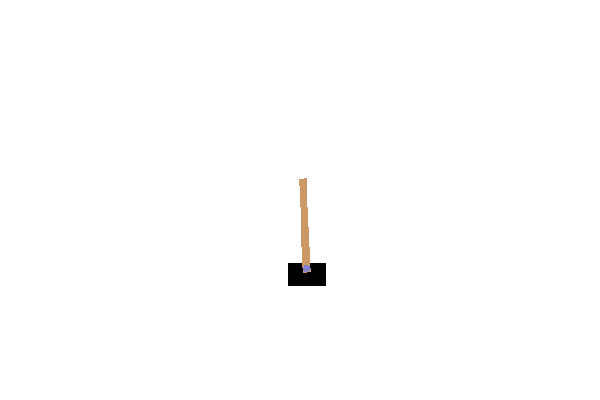
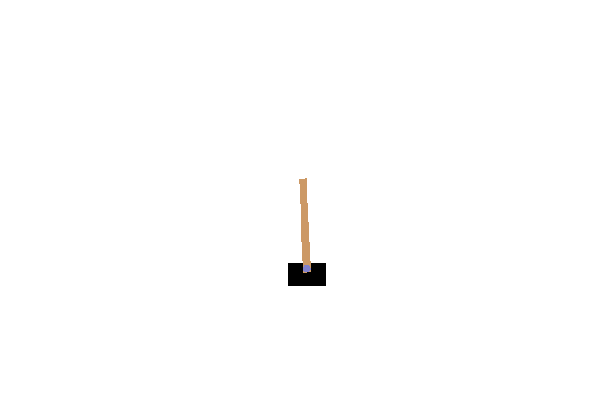
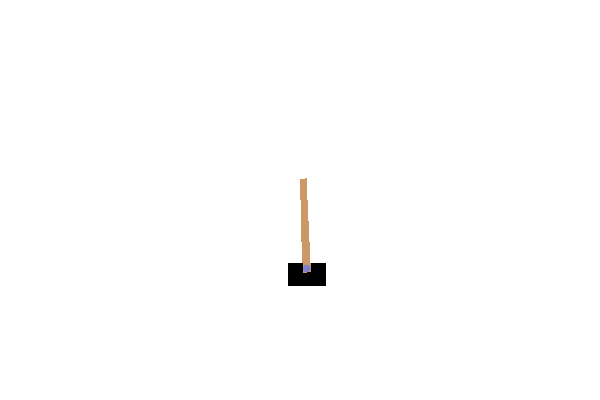
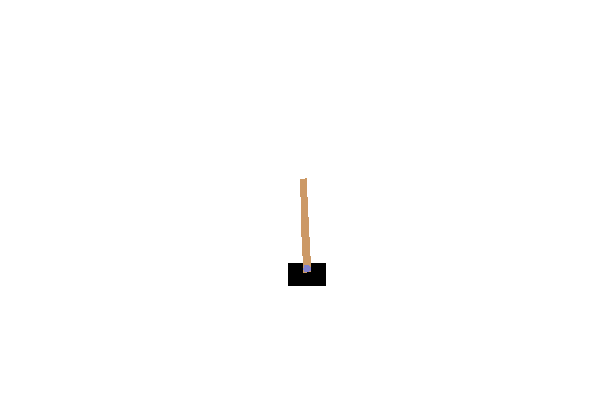
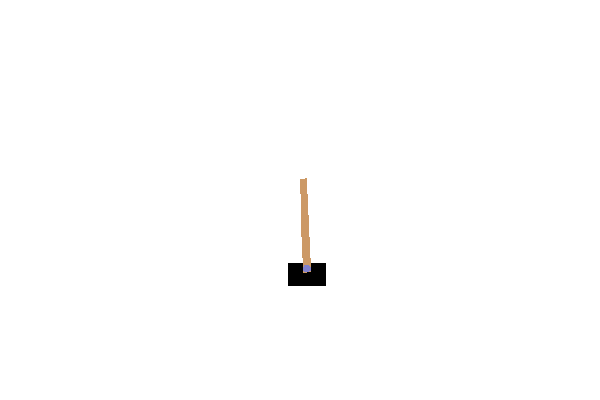
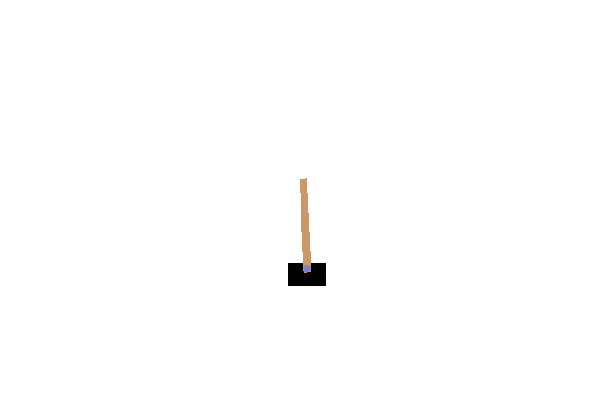
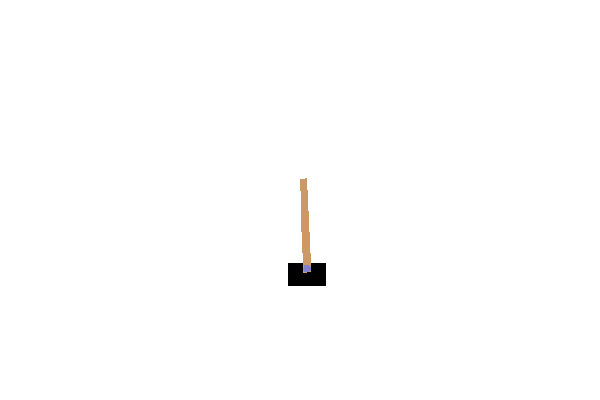
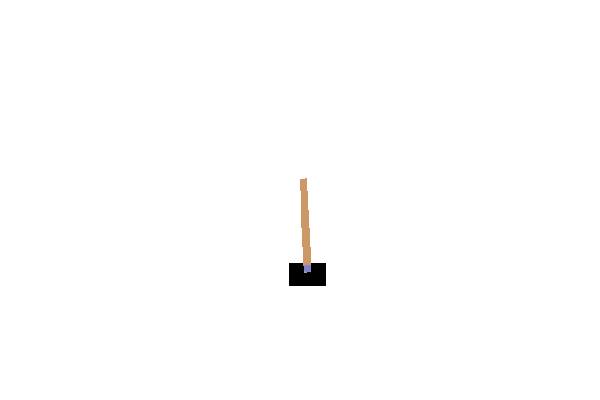
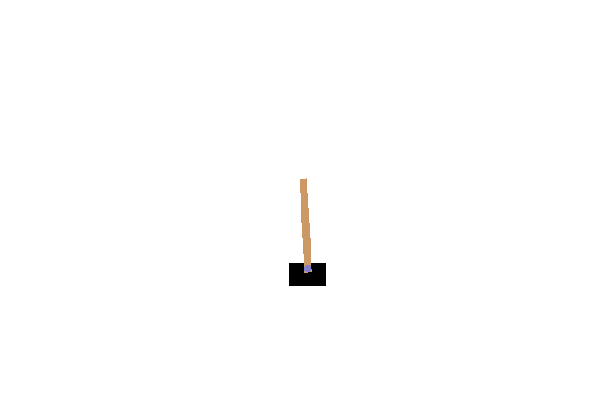
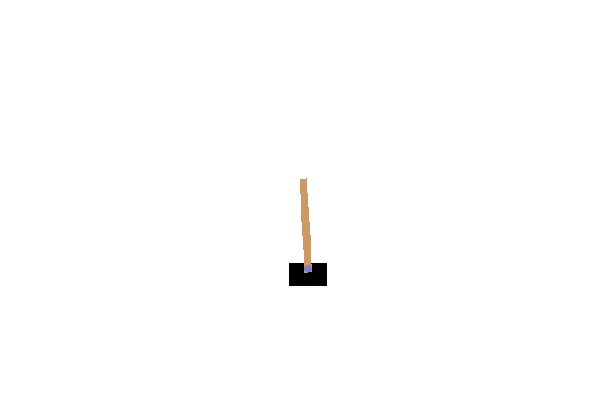
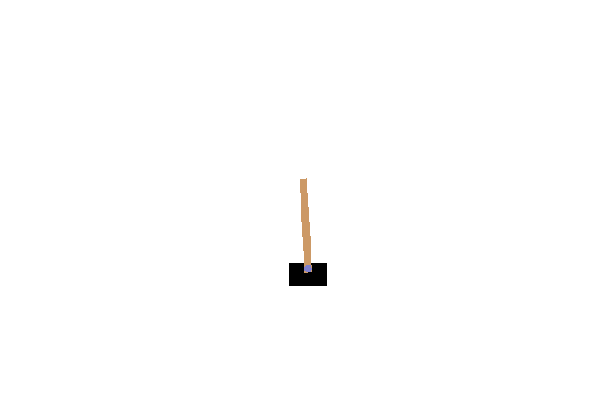
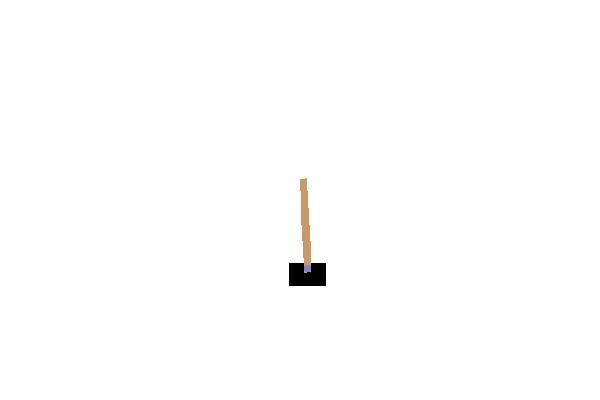
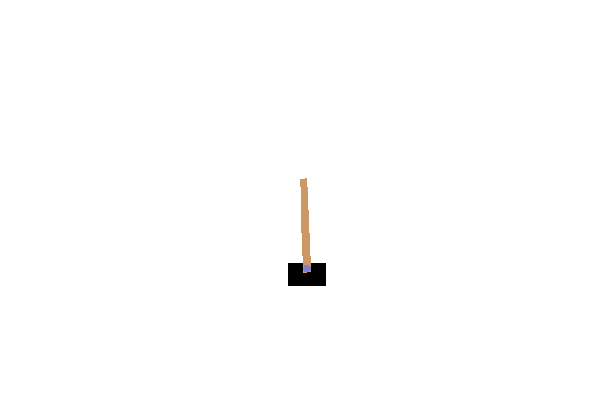
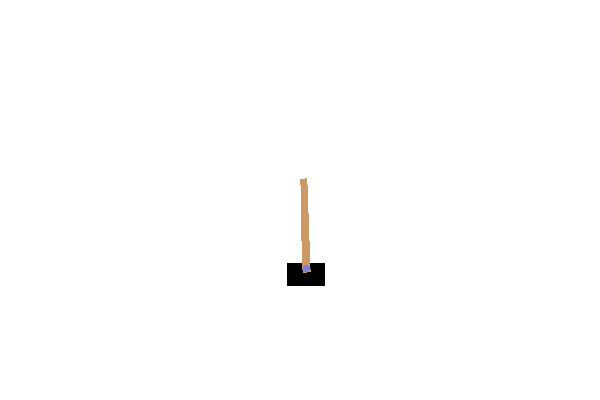
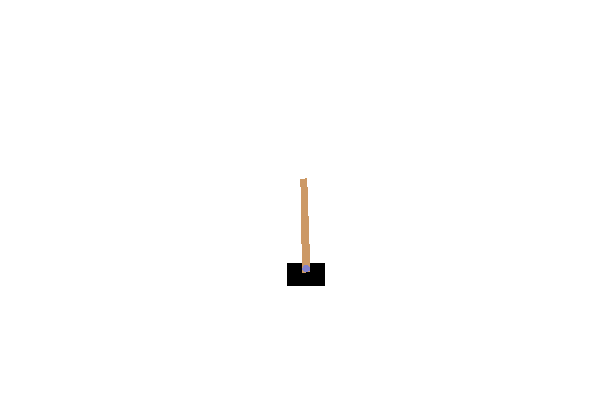
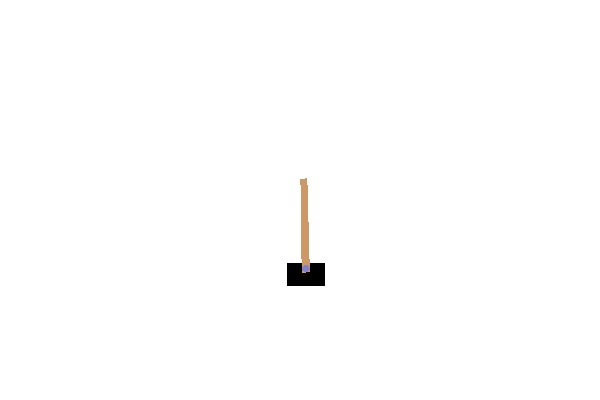
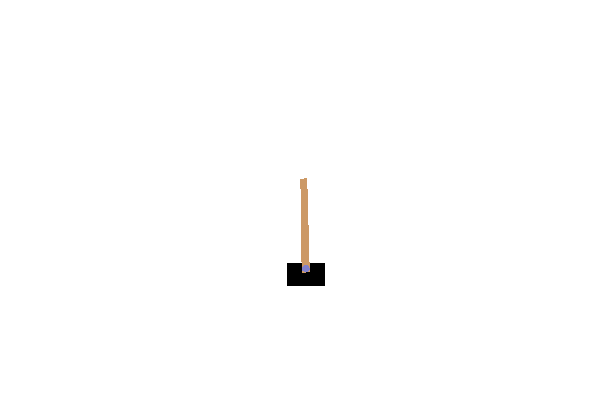
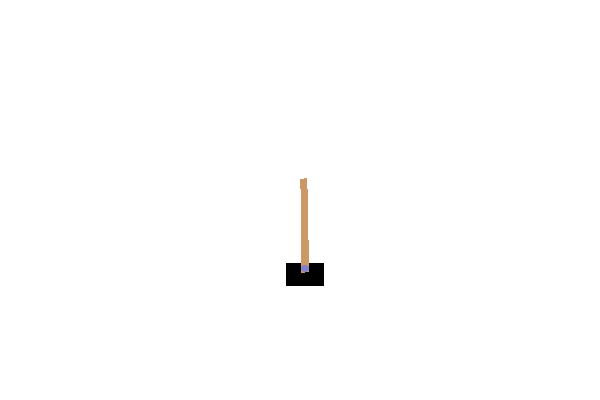
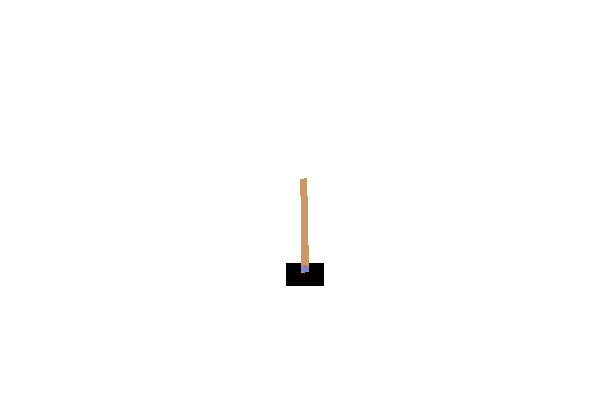
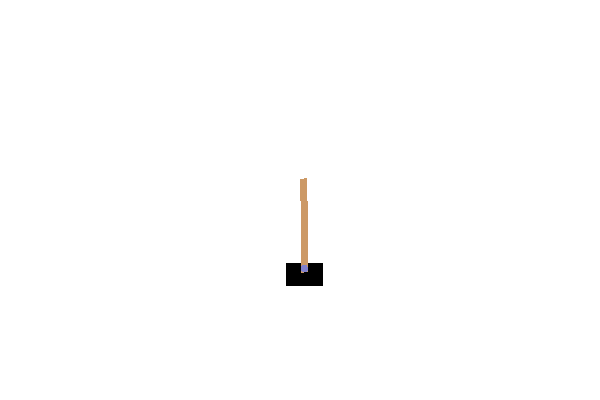
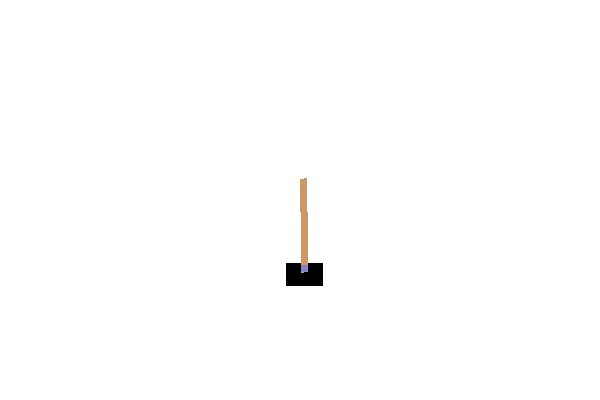
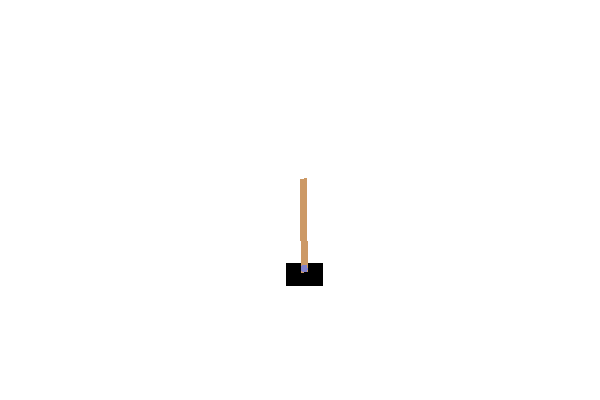
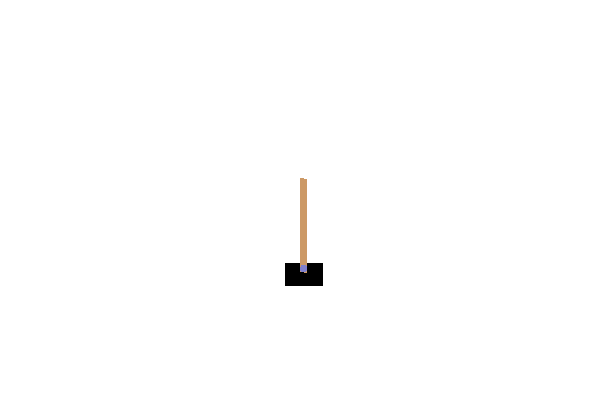
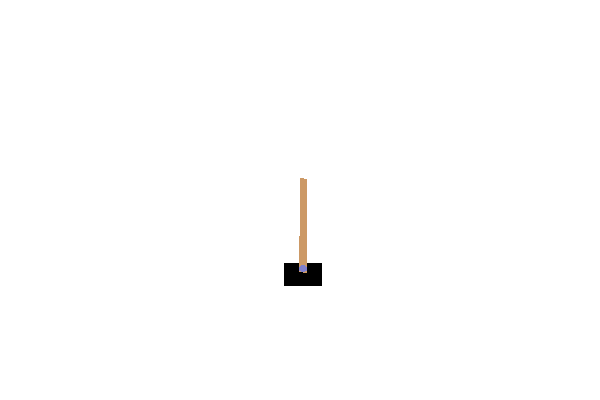
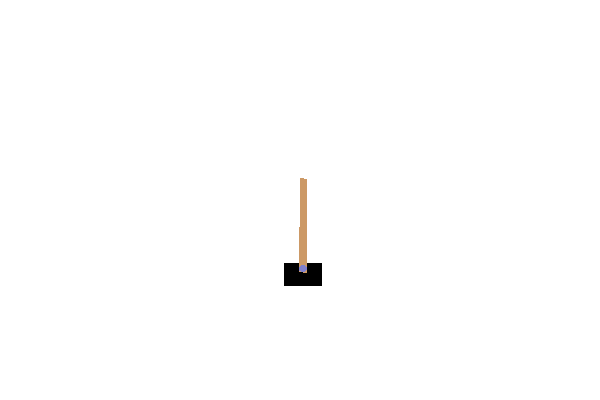
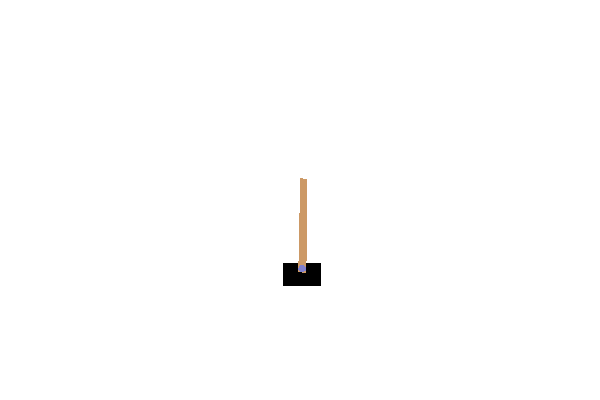
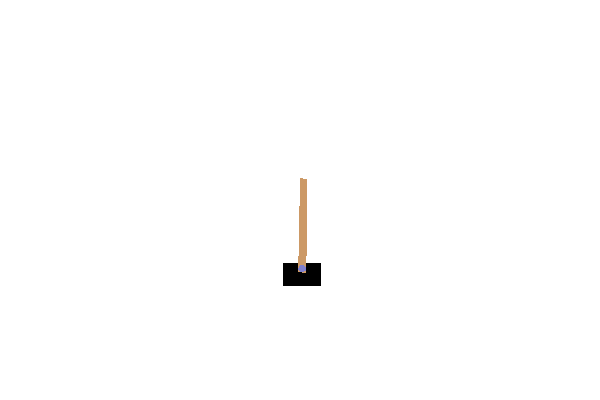
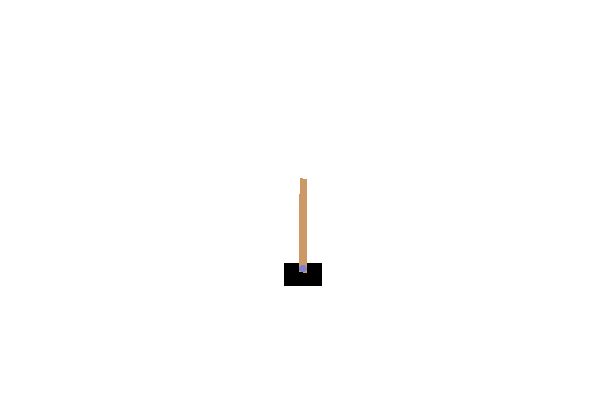
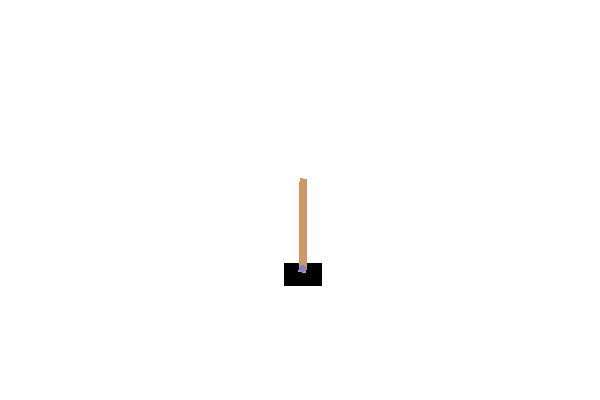
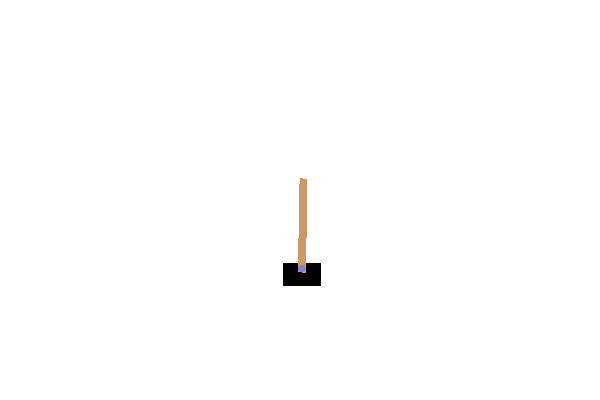
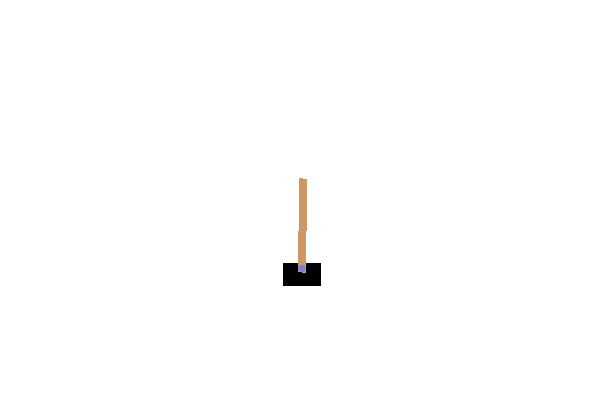
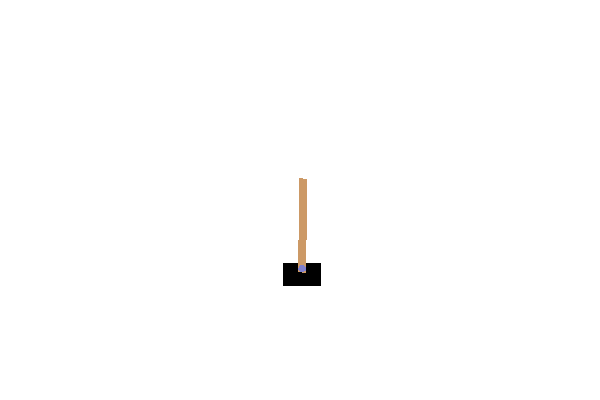
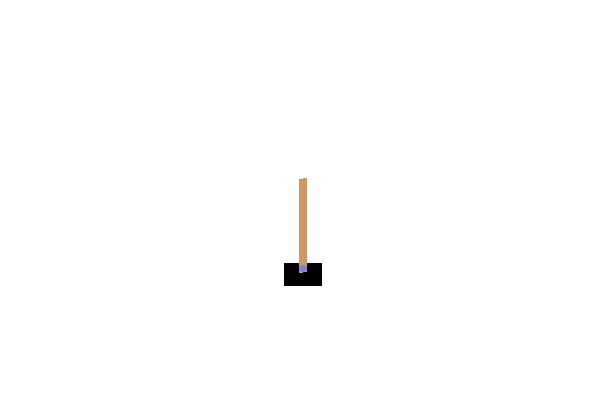
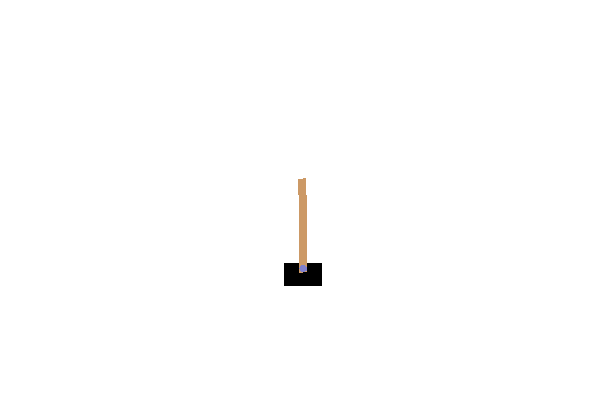
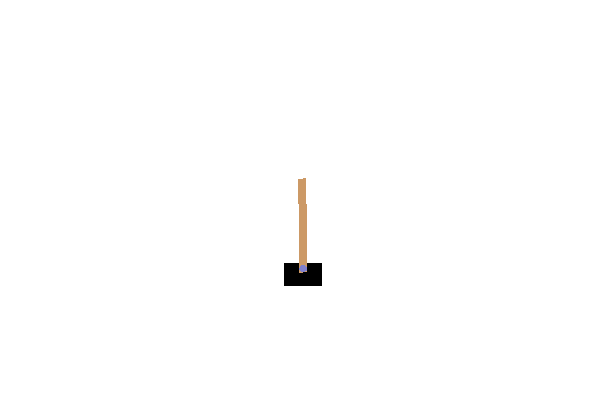
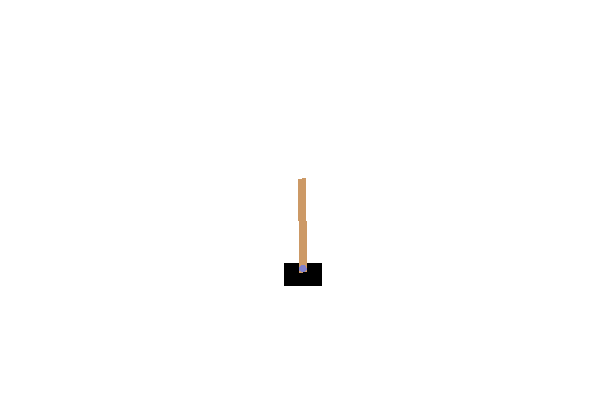
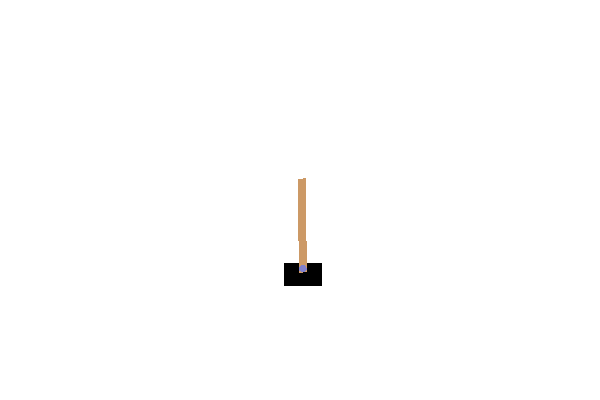
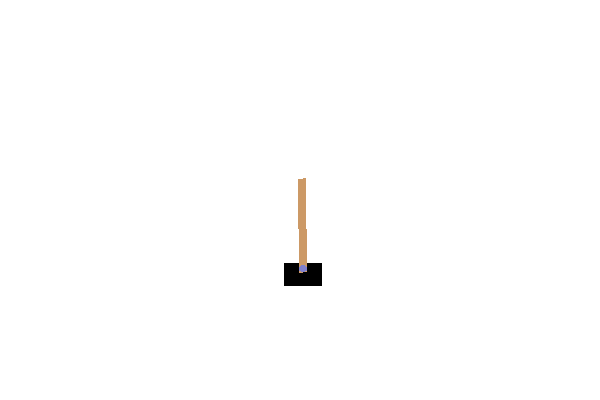
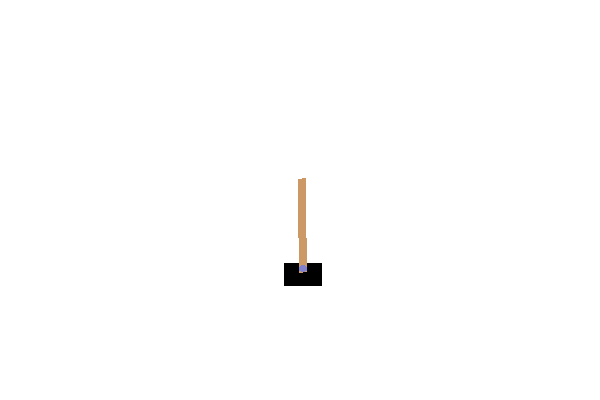
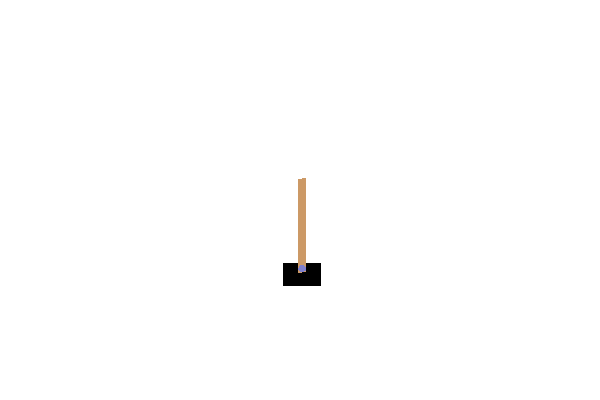
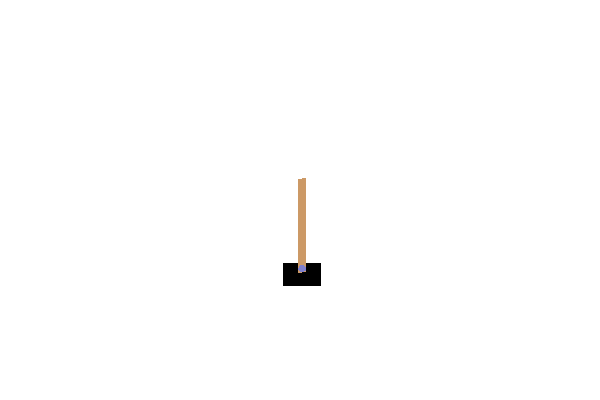
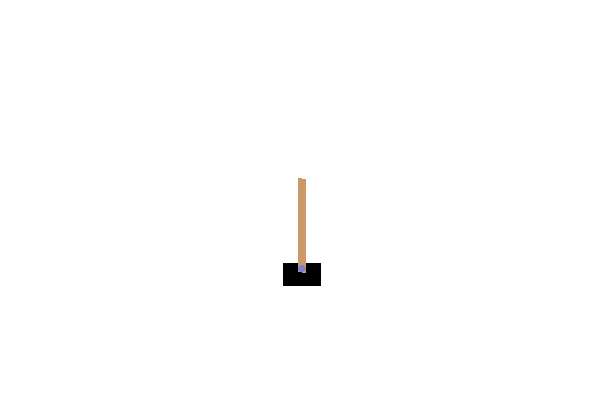
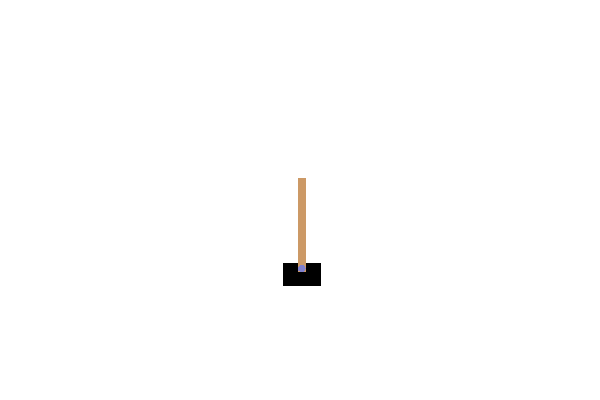
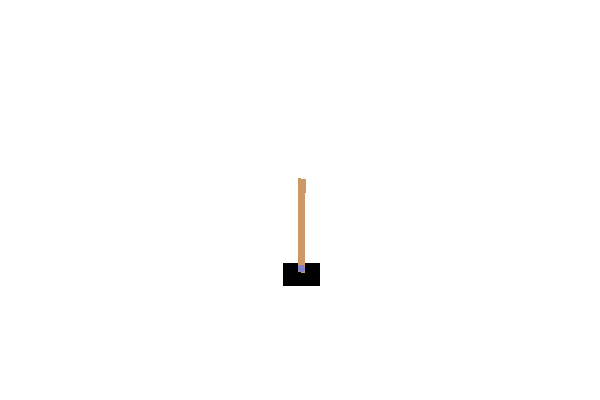
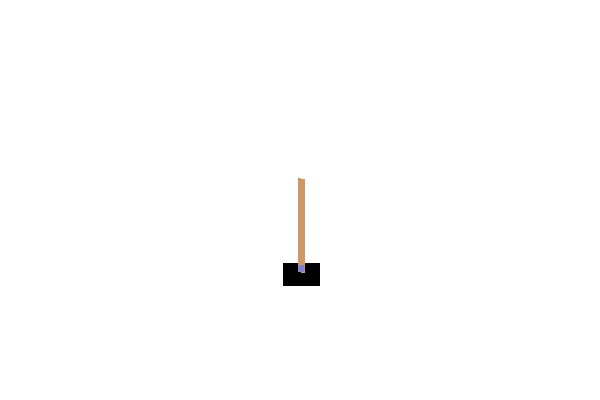
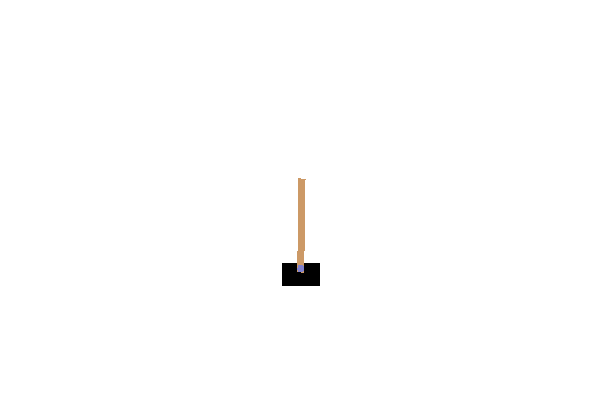
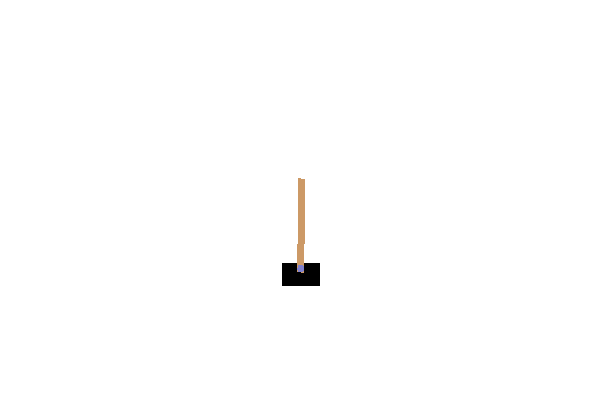
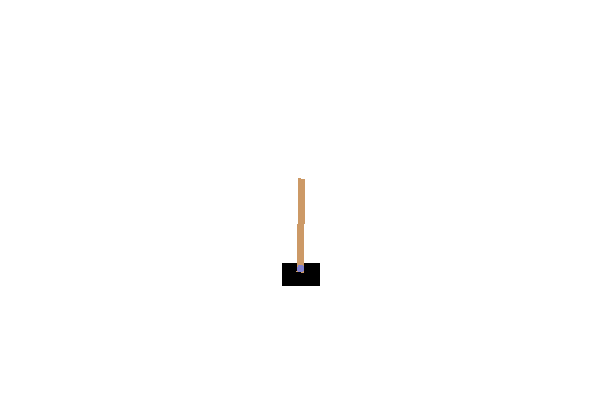
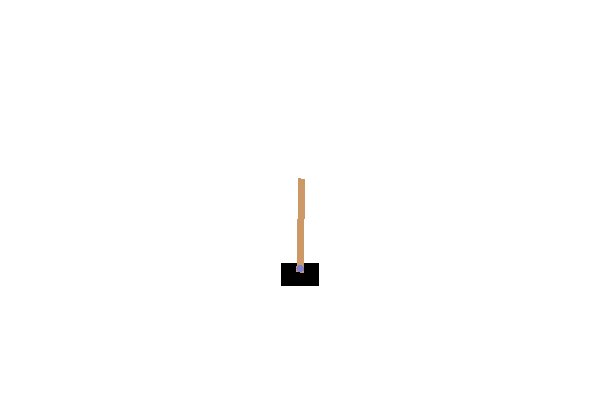
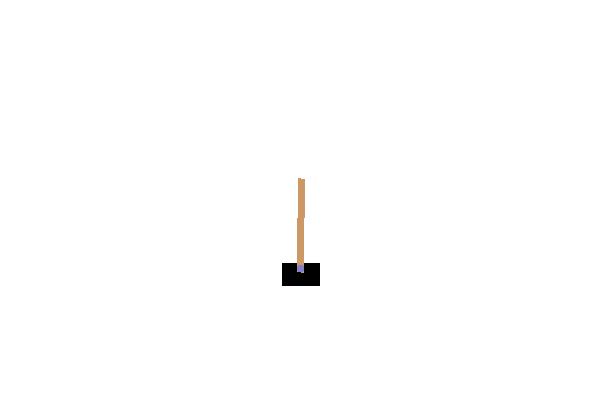
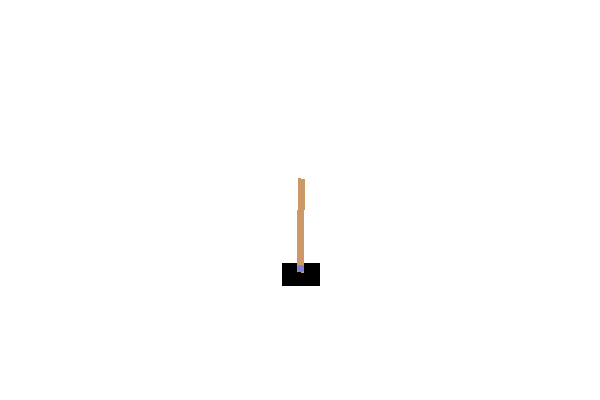
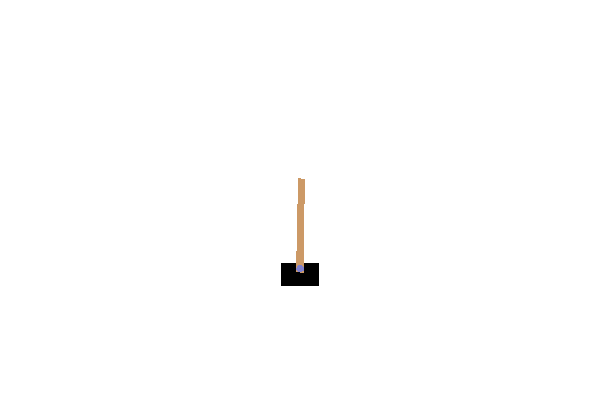
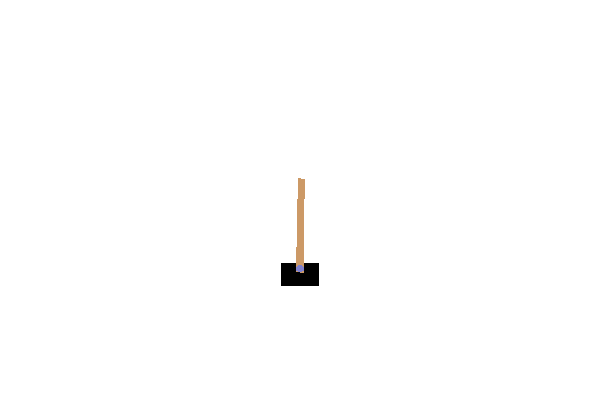
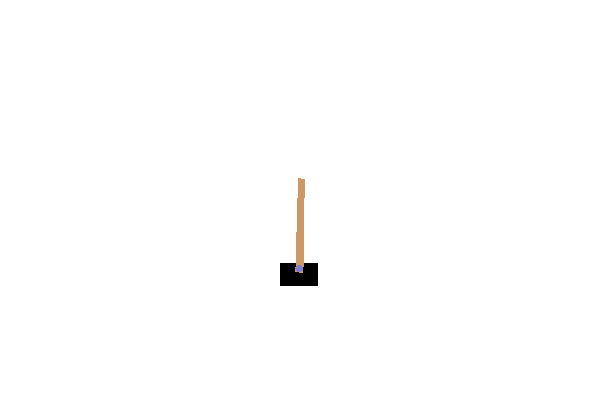
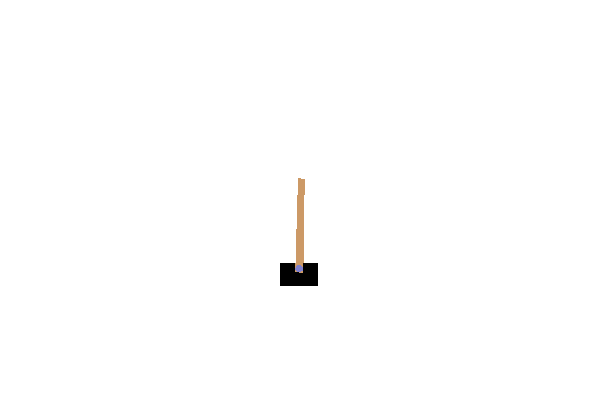
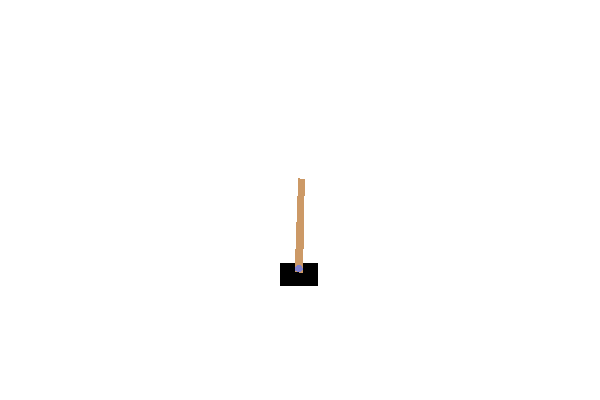
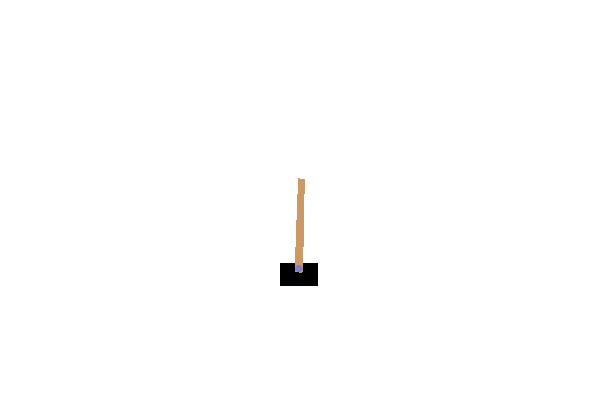
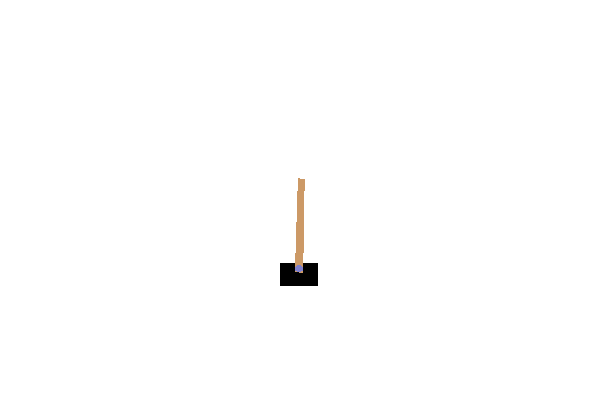
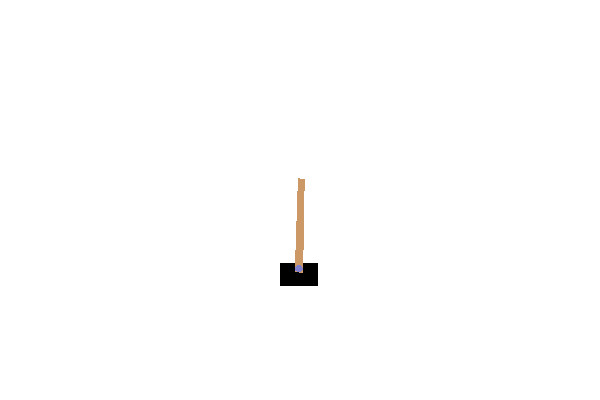
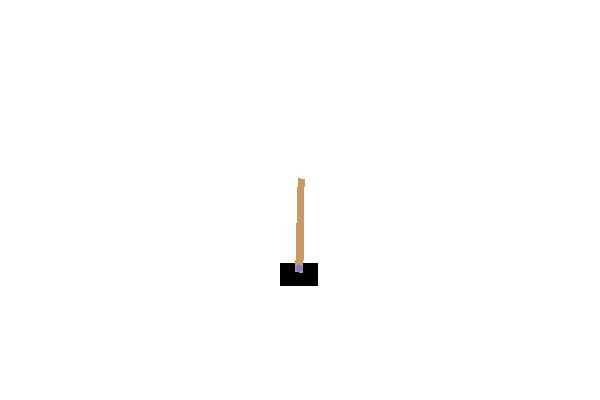
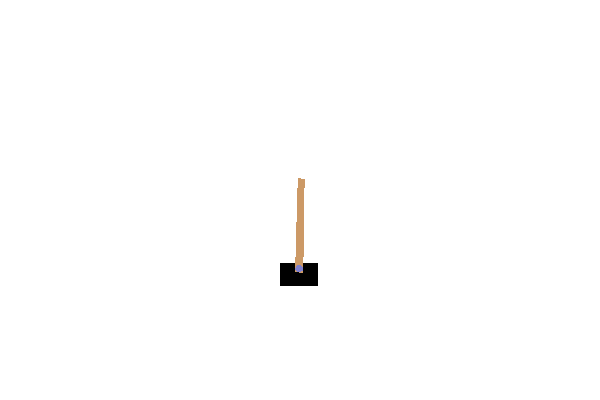
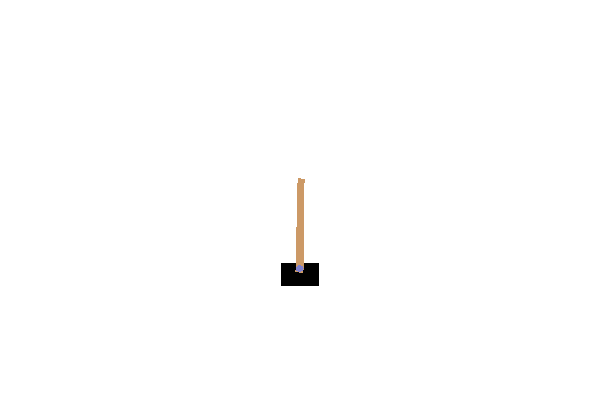
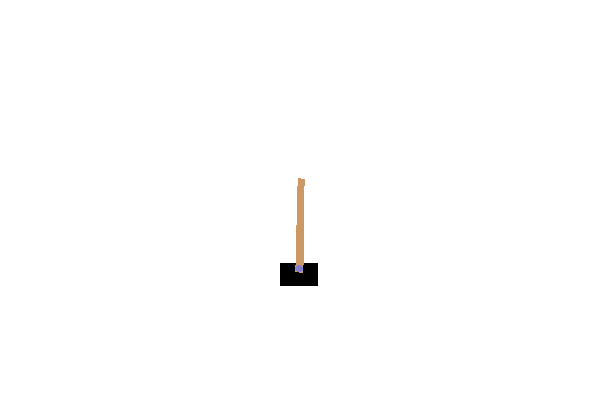
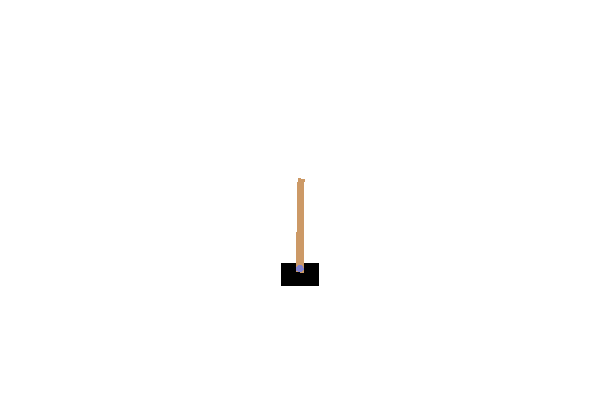
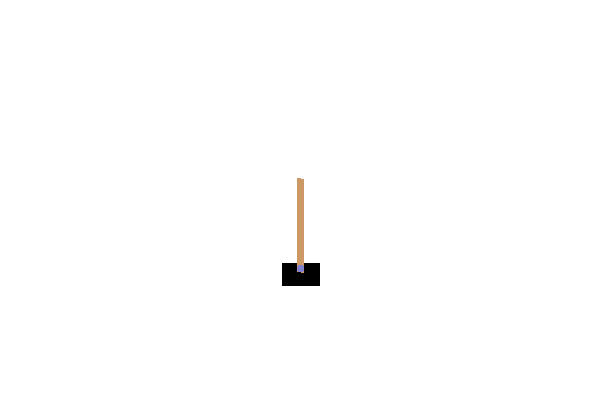
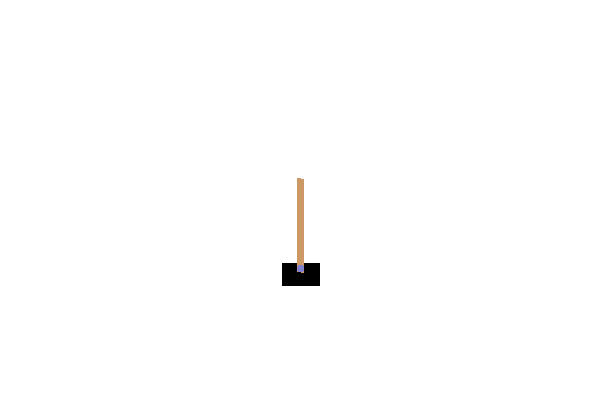
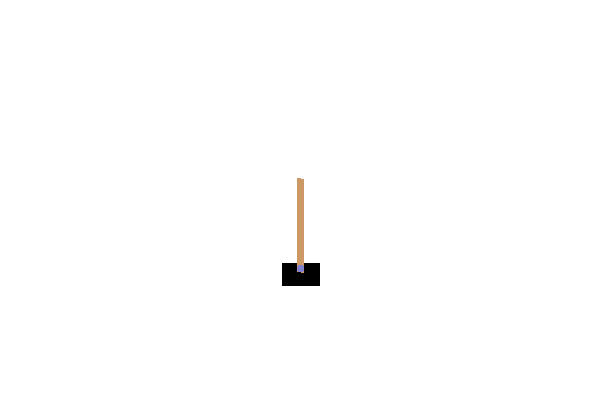
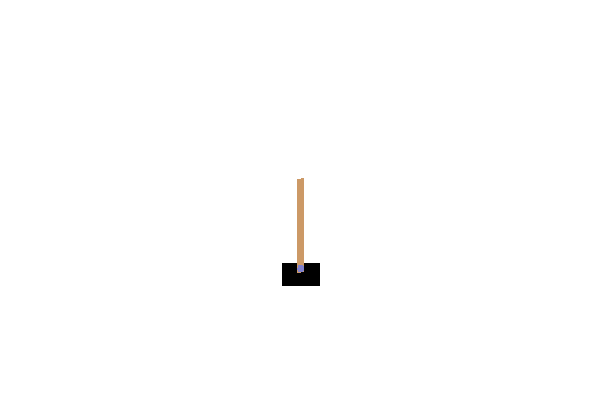
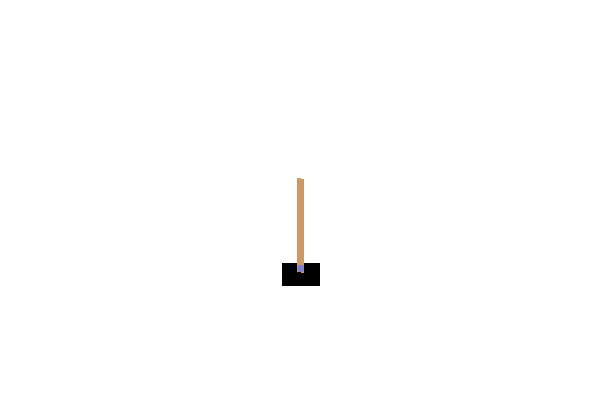
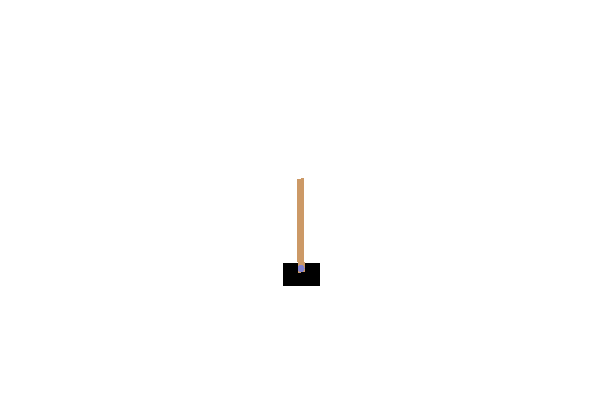
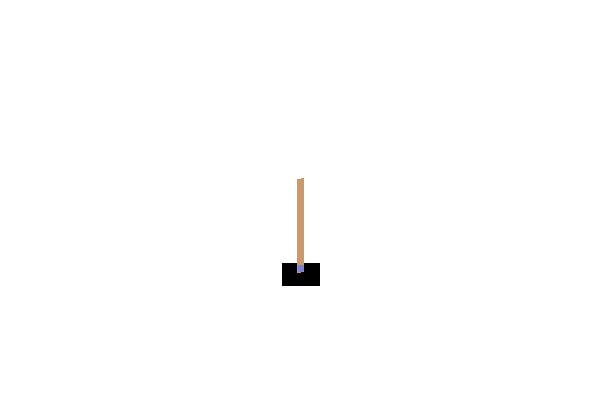
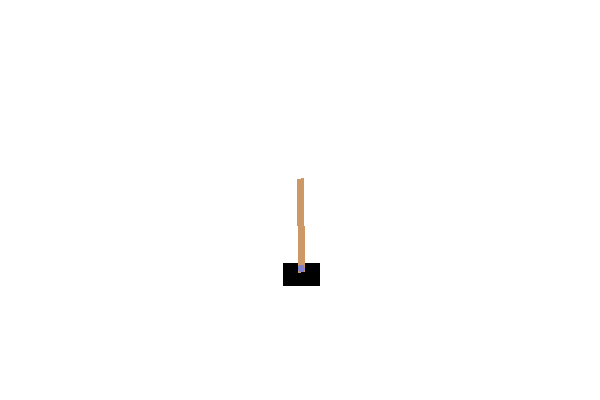
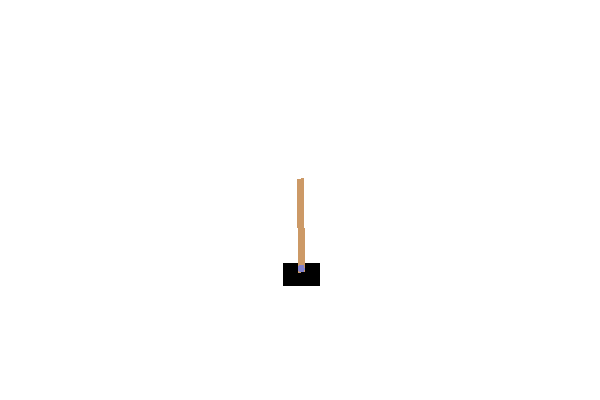
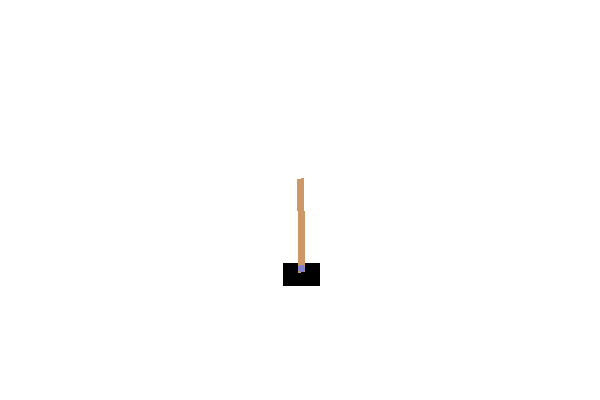
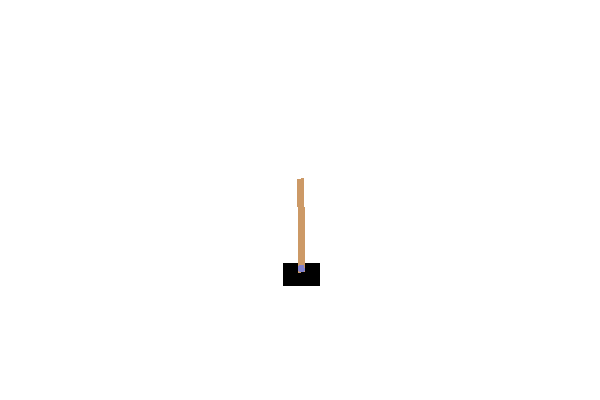
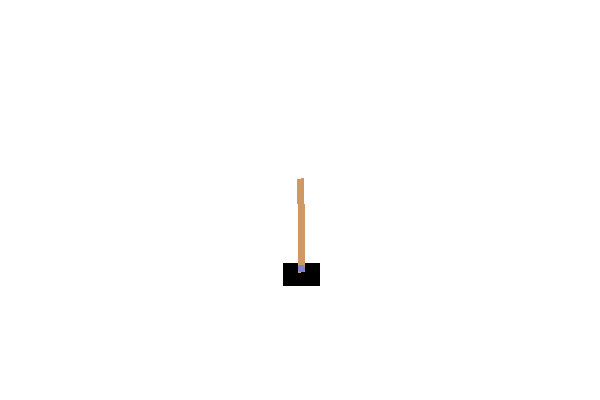
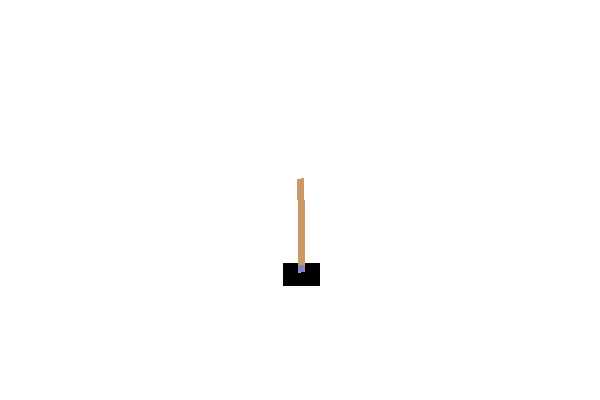
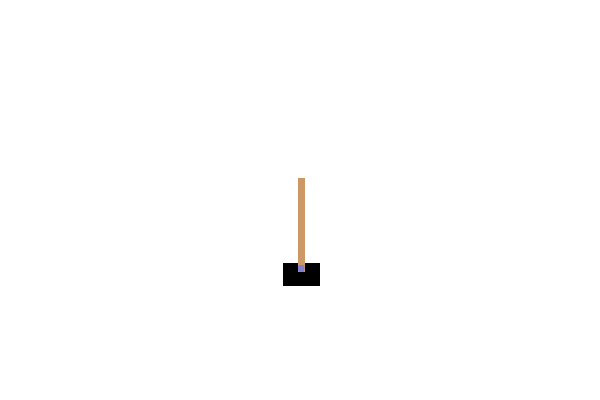
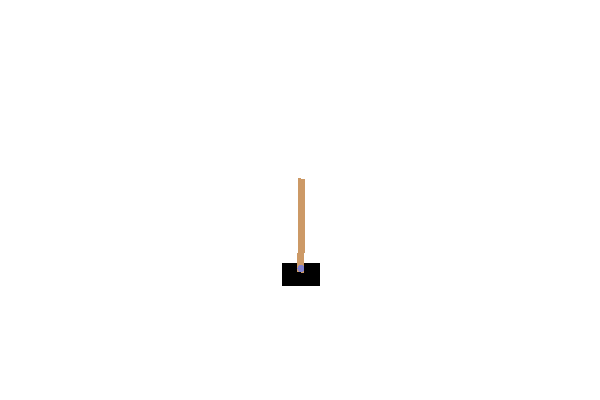
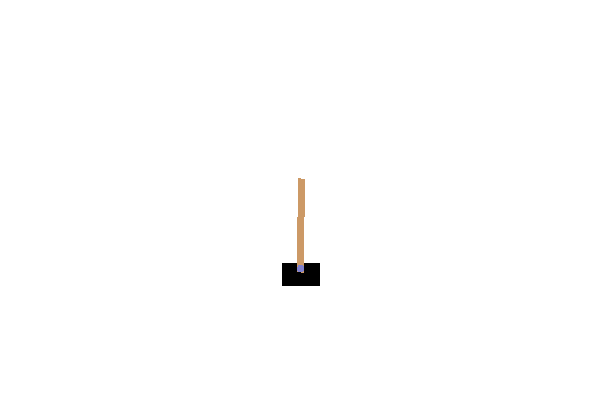
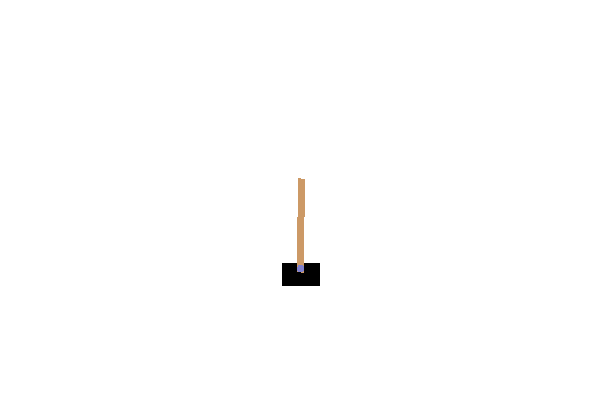
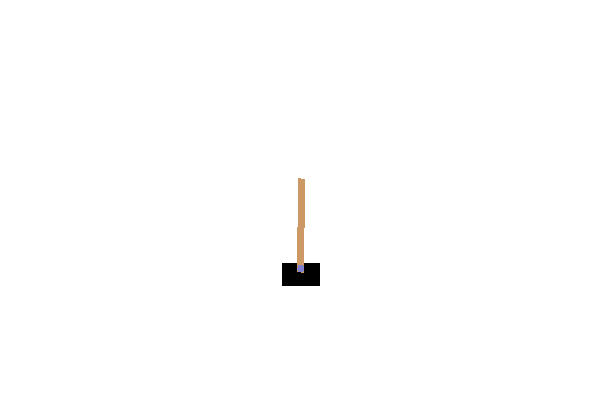
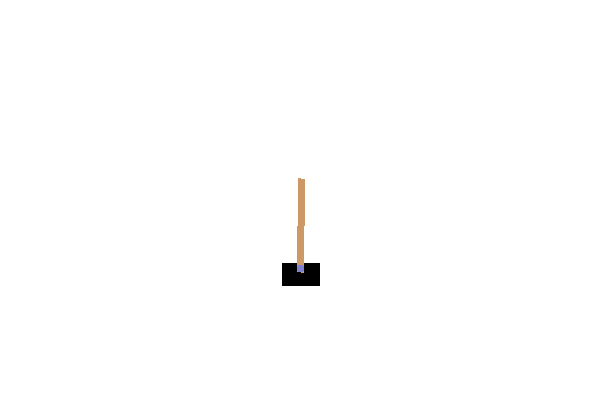
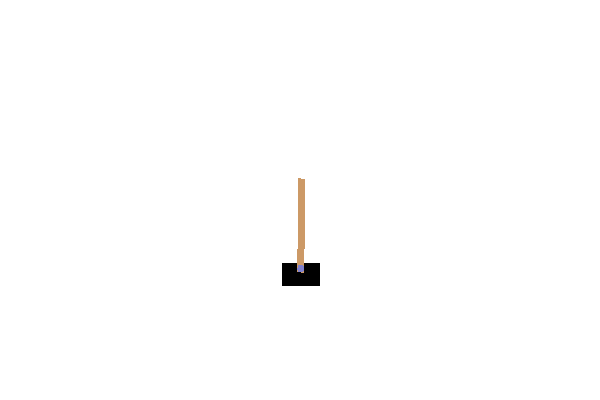
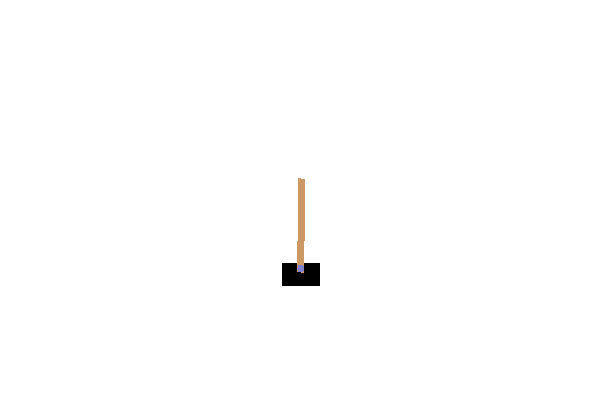
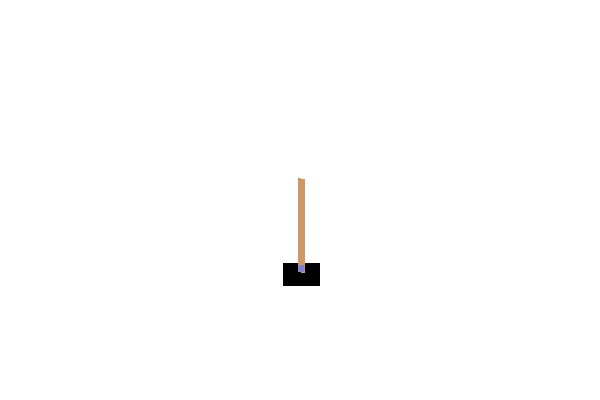
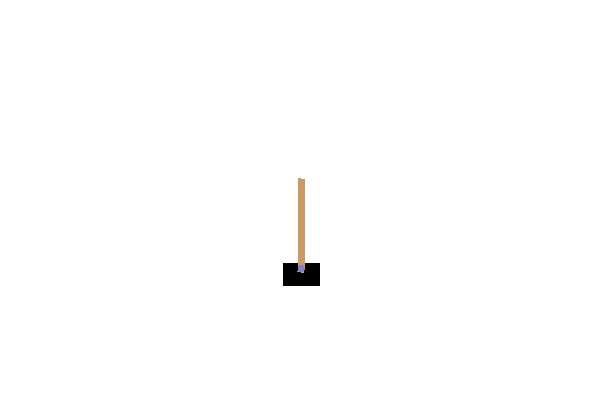
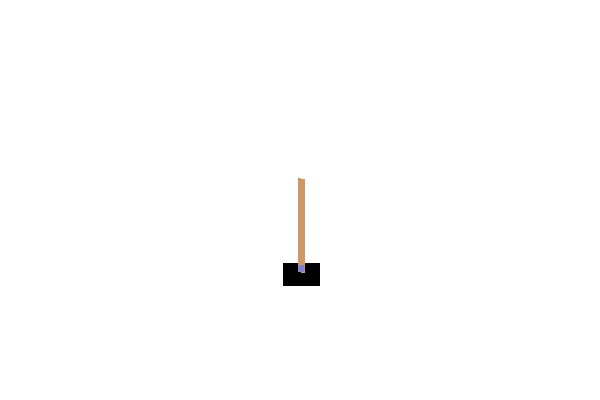
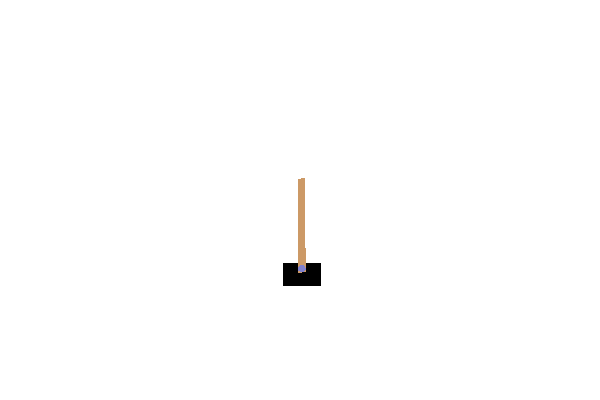
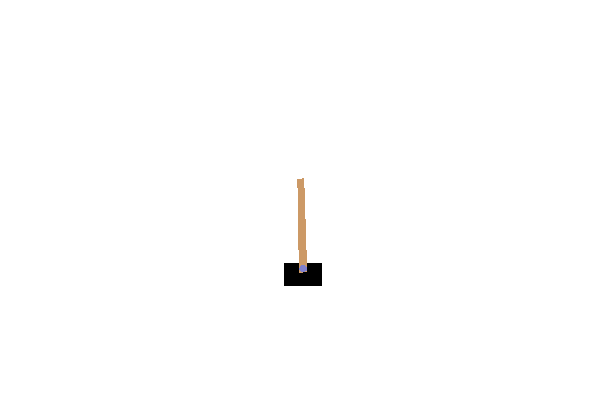
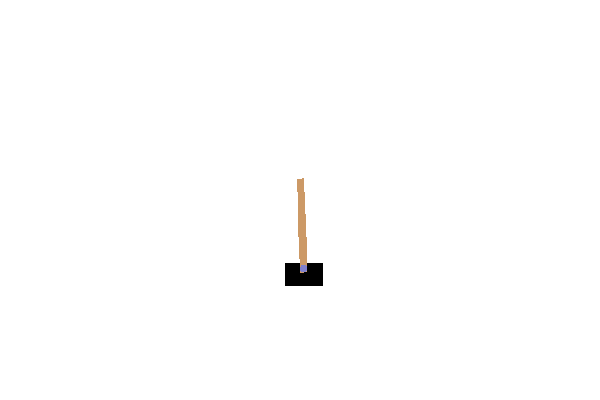
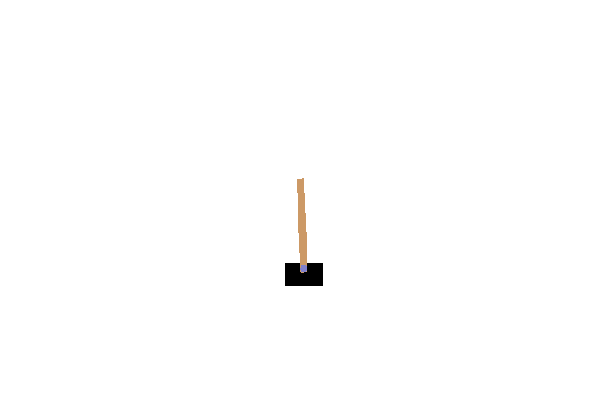
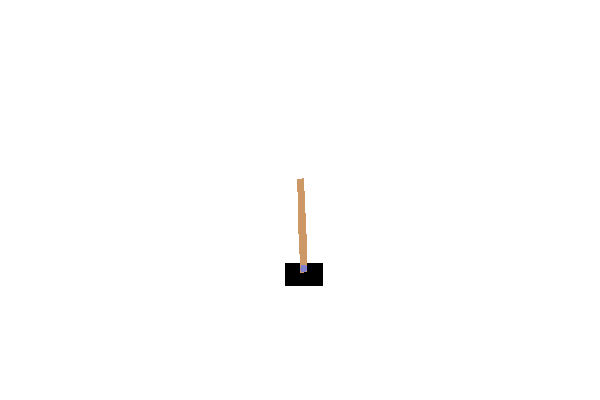
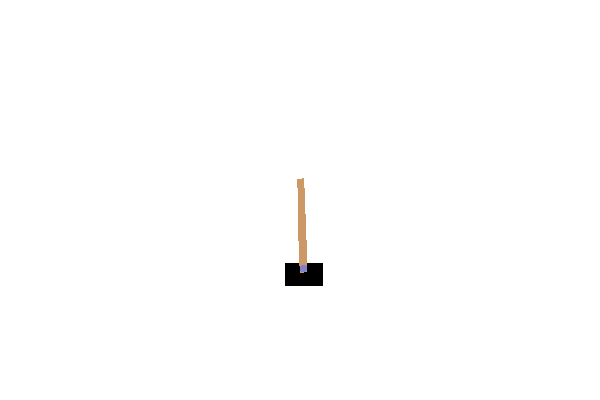
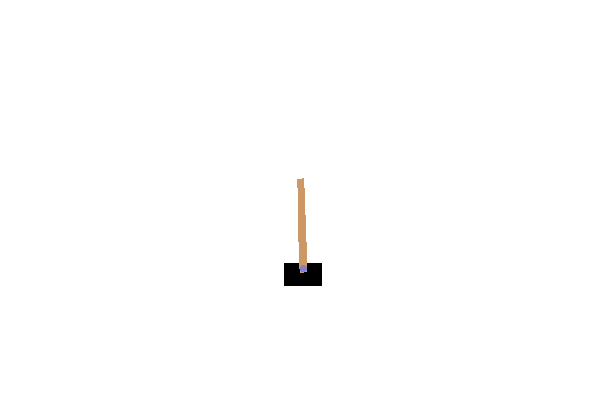
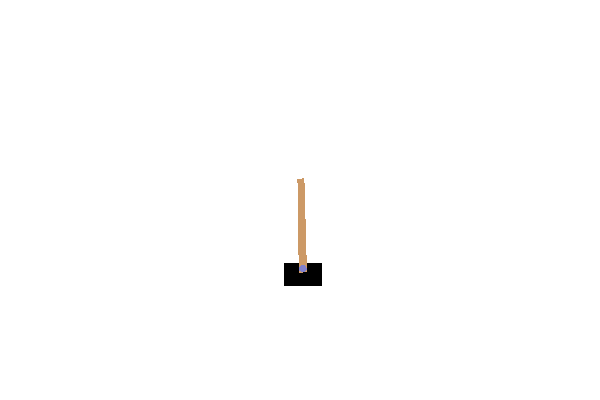
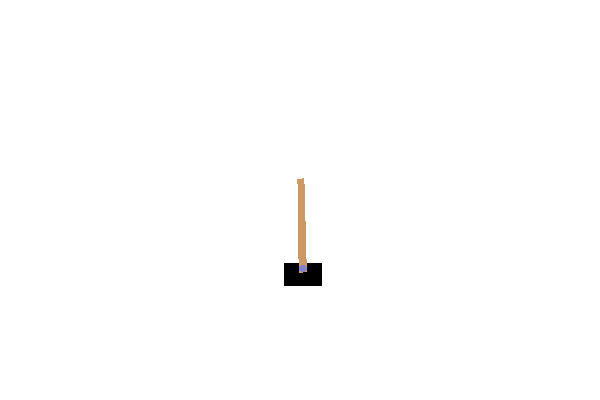
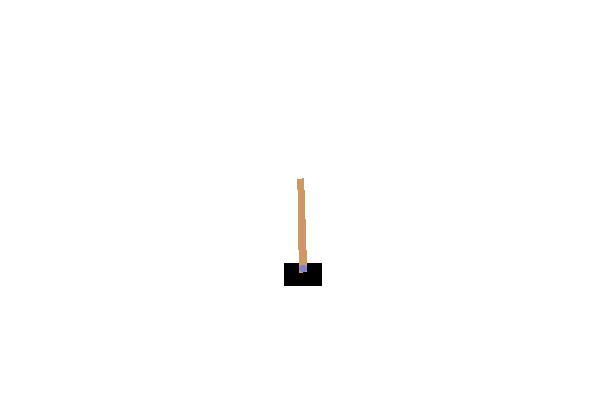
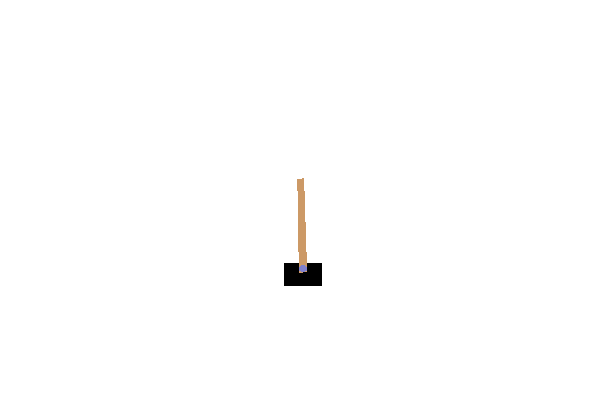
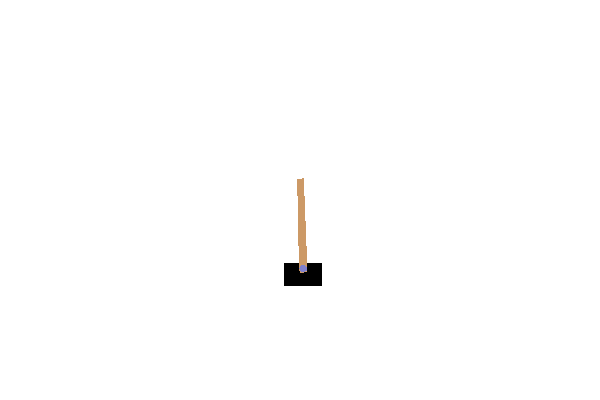
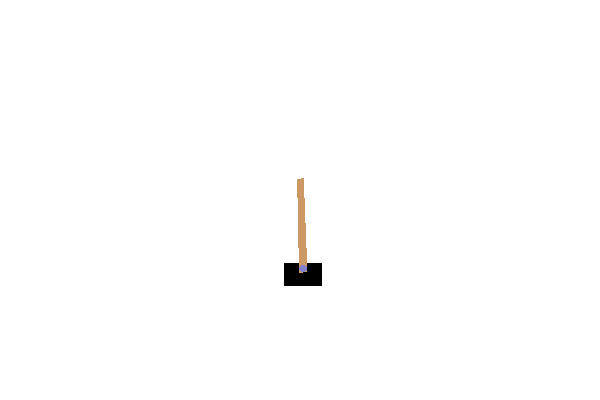
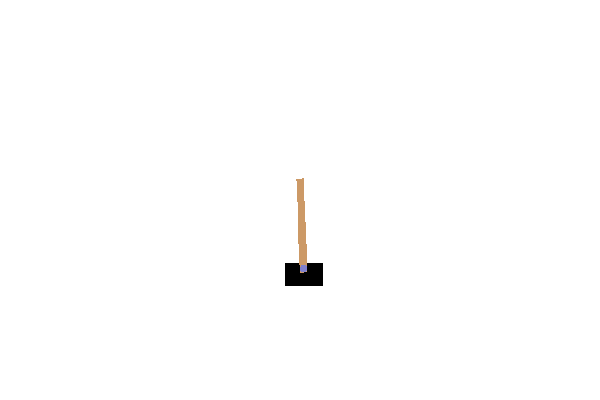
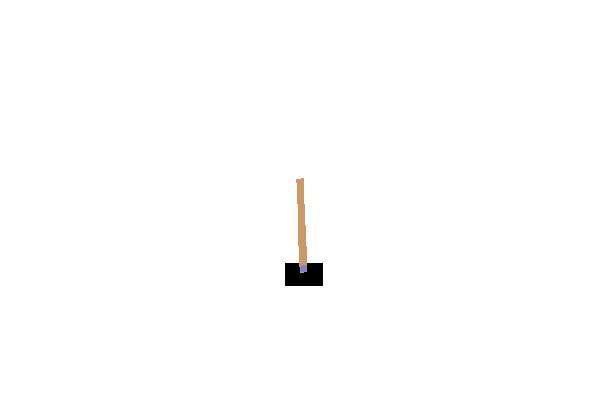
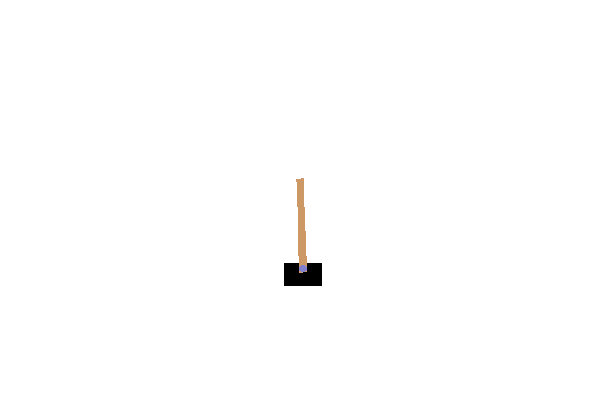
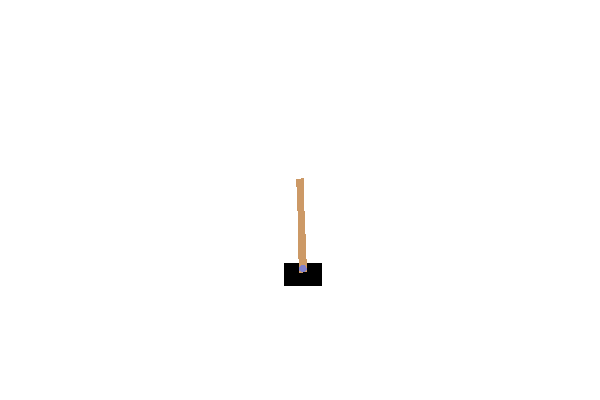
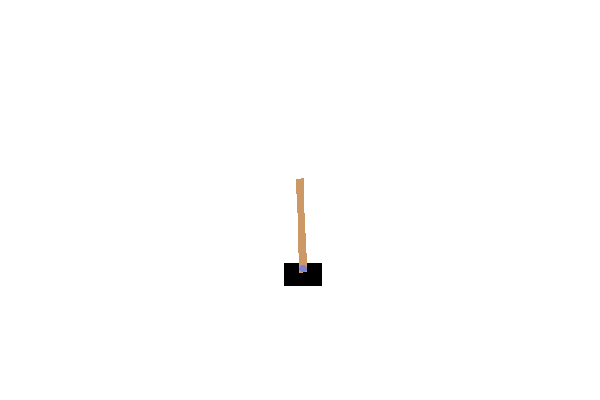
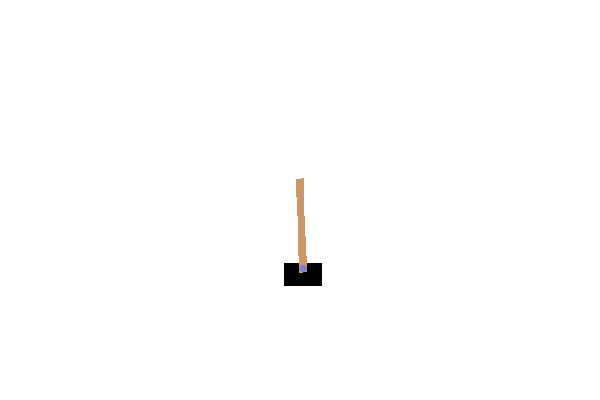
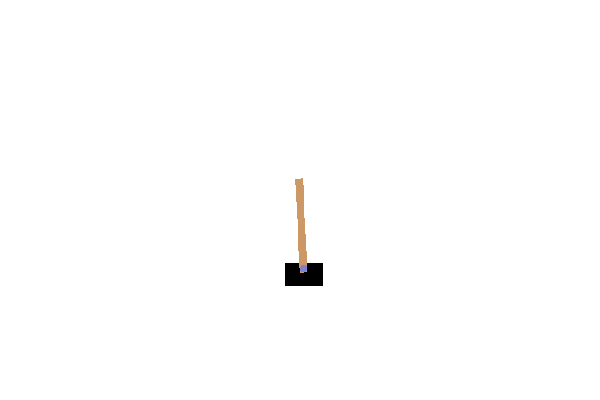
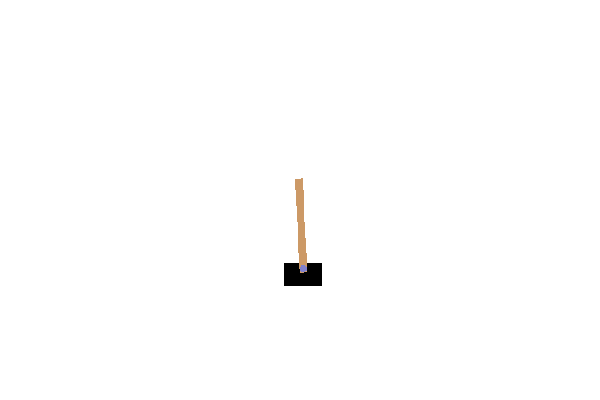
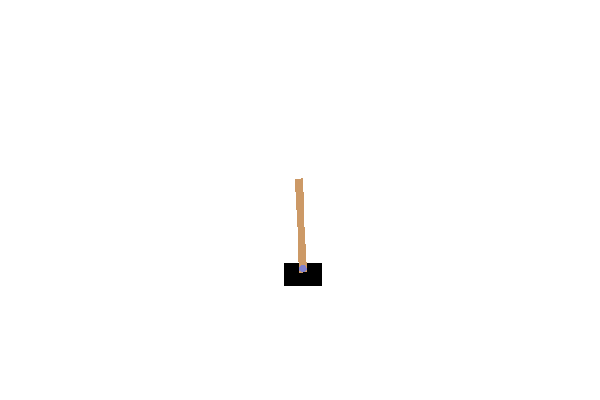
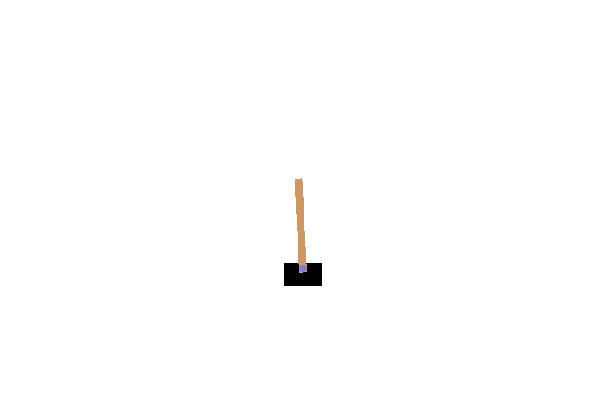
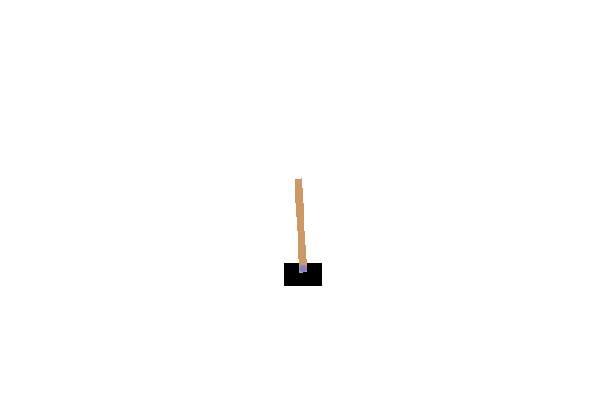
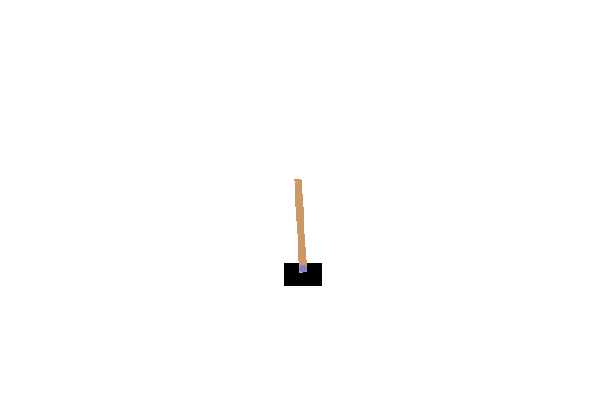

In [11]:
display_frames_as_gif(best_episode_frames, filename_gif="manualplay.gif")

In [12]:
best_episode_frames

[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  